In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict

In [3]:
# 데이터 로드
books_df = pd.read_csv('../data/books.csv')
users_df = pd.read_csv('../data/users.csv')
train_ratings_df = pd.read_csv('../data/train_ratings.csv')
test_ratings_df = pd.read_csv('../data/test_ratings.csv')

In [81]:
# train과 test의 user_id와 isbn 쌍을 튜플로 만들어서 비교
train_pairs = set(zip(train_ratings_df['user_id'], train_ratings_df['isbn']))
test_pairs = set(zip(test_ratings_df['user_id'], test_ratings_df['isbn']))

# 중복되는 쌍 찾기
overlapping_pairs = train_pairs.intersection(test_pairs)

print(f"중복되는 (user_id, isbn) 쌍의 수: {len(overlapping_pairs)}")

if len(overlapping_pairs) > 0:
    print("\n처음 5개 중복 쌍:")
    for pair in list(overlapping_pairs)[:5]:
        print(f"user_id: {pair[0]}, isbn: {pair[1]}")
    
    # 중복되는 쌍의 train과 test에서의 rating 비교
    for pair in list(overlapping_pairs)[:5]:
        train_rating = train_ratings_df[(train_ratings_df['user_id'] == pair[0]) & 
                                      (train_ratings_df['isbn'] == pair[1])]['rating'].iloc[0]
        test_rating = test_ratings_df[(test_ratings_df['user_id'] == pair[0]) & 
                                    (test_ratings_df['isbn'] == pair[1])]['rating'].iloc[0]
        print(f"\nuser_id {pair[0]}, isbn {pair[1]}:")
        print(f"Train rating: {train_rating}")
        print(f"Test rating: {test_rating}")

중복되는 (user_id, isbn) 쌍의 수: 0


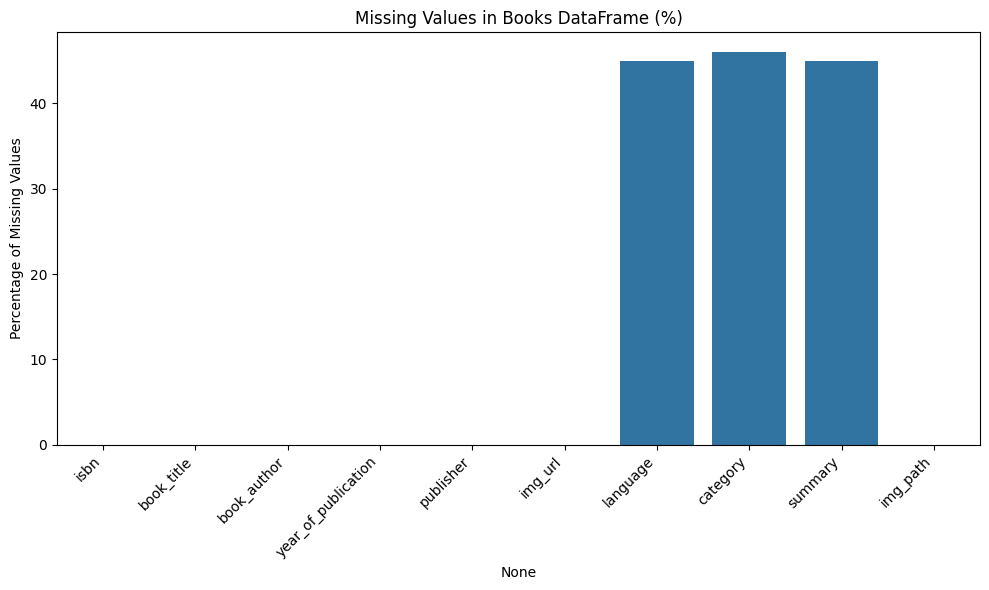

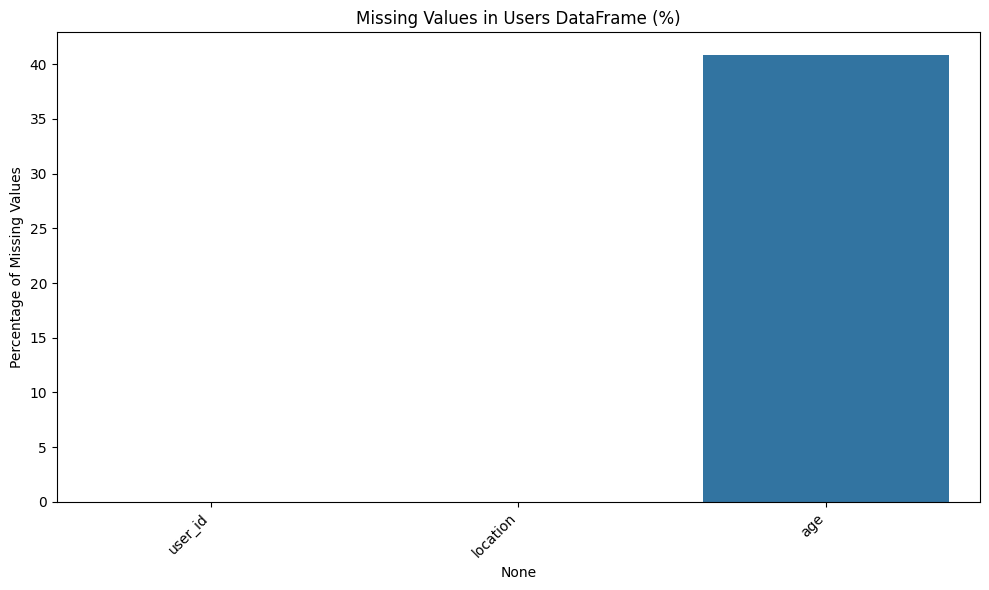

In [4]:
# 1. 결측치 시각화
def plot_missing_values(df, title):
    plt.figure(figsize=(10, 6))
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    
    sns.barplot(x=missing_percent.index, y=missing_percent.values)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Missing Values in {title} (%)')
    plt.ylabel('Percentage of Missing Values')
    plt.tight_layout()
    plt.show()

plot_missing_values(books_df, 'Books DataFrame')
plot_missing_values(users_df, 'Users DataFrame')

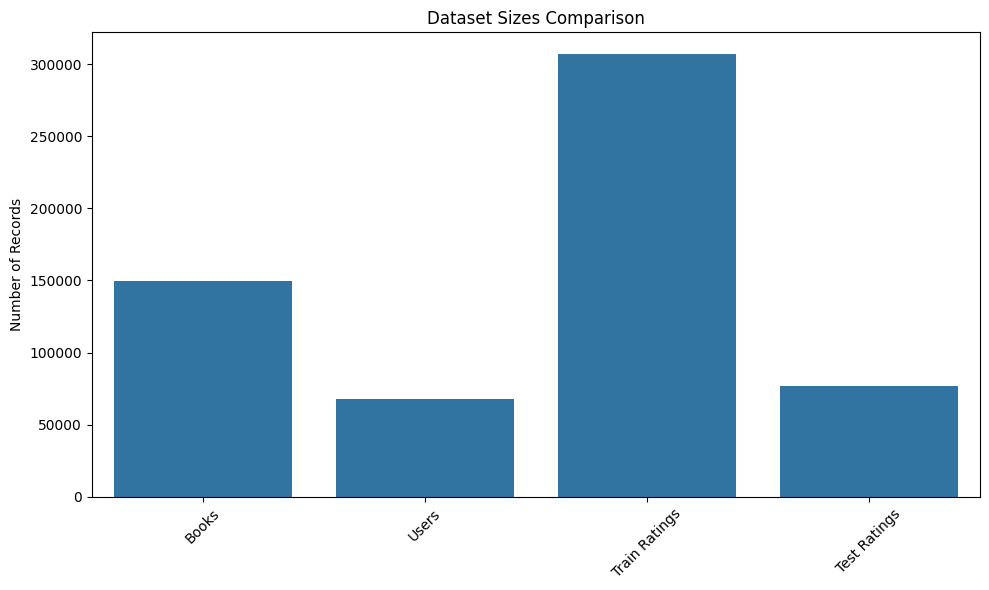

In [5]:
# 3. 데이터셋 크기 비교
plt.figure(figsize=(10, 6))
dataset_sizes = {
    'Books': len(books_df),
    'Users': len(users_df),
    'Train Ratings': len(train_ratings_df),
    'Test Ratings': len(test_ratings_df)
}
sns.barplot(x=list(dataset_sizes.keys()), y=list(dataset_sizes.values()))
plt.title('Dataset Sizes Comparison')
plt.ylabel('Number of Records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

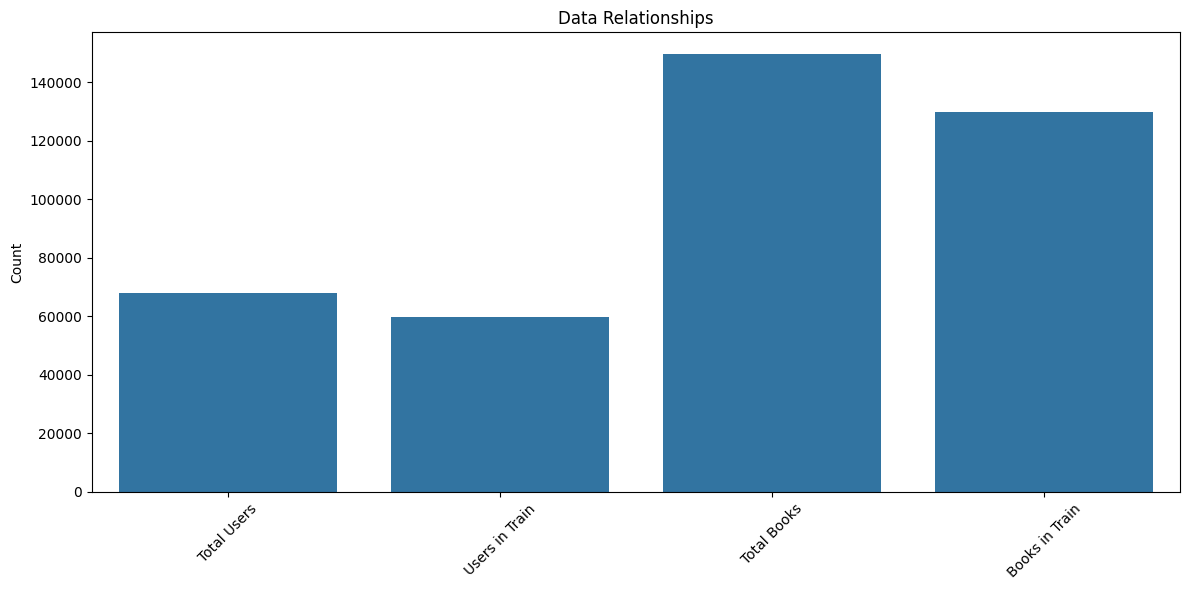

In [6]:
# 4. 데이터 관계 시각화
plt.figure(figsize=(12, 6))
relationships = {
    'Total Users': len(users_df),
    'Users in Train': len(train_ratings_df['user_id'].unique()),
    'Total Books': len(books_df),
    'Books in Train': len(train_ratings_df['isbn'].unique())
}
sns.barplot(x=list(relationships.keys()), y=list(relationships.values()))
plt.title('Data Relationships')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Total Users (~67,000) vs Users in Train (~59,000)

전체 사용자 중 약 88%가 학습 데이터에 포함됨
약 8,000명의 사용자는 train 데이터에 없음
이는 일부 사용자가 test 데이터에만 있거나 평점을 전혀 남기지 않았을 수 있음을 의미

Total Books (~147,000) vs Books in Train (~130,000)

전체 책의 약 88%가 학습 데이터에서 최소 한 번 이상 평가됨
약 17,000권의 책은 train 데이터에 없음

둘 다 12%는 test인가?

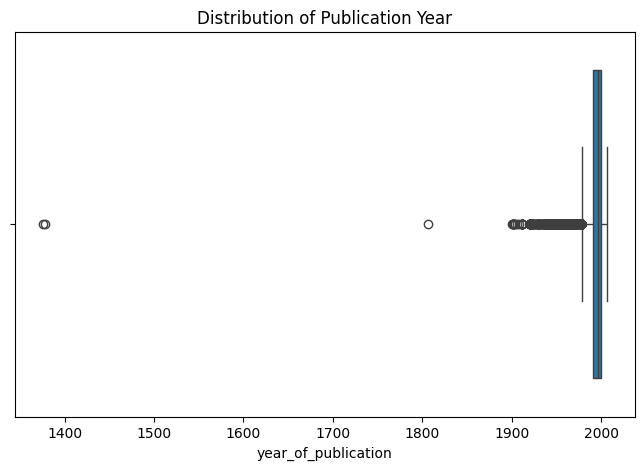


Basic Statistics for Publication Year:
count    149570.000000
mean       1994.590606
std           8.179733
min        1376.000000
25%        1991.000000
50%        1996.000000
75%        2000.000000
max        2006.000000
Name: year_of_publication, dtype: float64


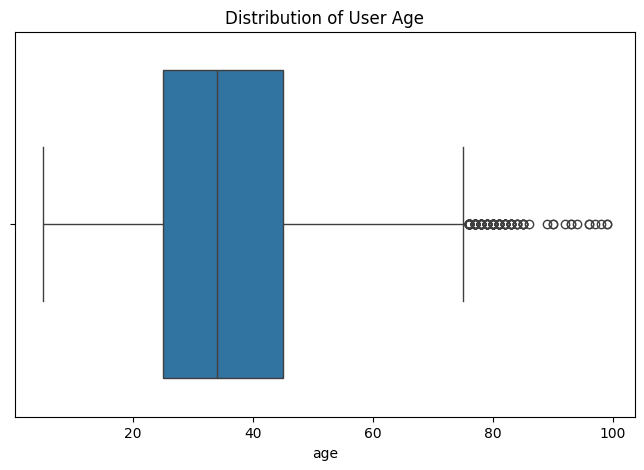


Basic Statistics for User Age:
count    40259.000000
mean        36.069873
std         13.842571
min          5.000000
25%         25.000000
50%         34.000000
75%         45.000000
max         99.000000
Name: age, dtype: float64


In [7]:
# 5. 출판 연도 시각화
def plot_basic_stats(df, column, title):
    stats = df[column].describe()
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[column])
    plt.title(f'Distribution of {title}')
    plt.show()
    
    print(f"\nBasic Statistics for {title}:")
    print(stats)

plot_basic_stats(books_df, 'year_of_publication', 'Publication Year')
plot_basic_stats(users_df, 'age', 'User Age')

Publication Year 통계
- count: 149,570권 (결측치 없음)
- mean: 1994.59년 (평균 출판연도)
- std: 8.18년 (표준편차가 작아 대부분 비슷한 시기에 집중)
- min: 1376년 (명백한 이상치)
- 25%: 1991년
- 50%: 1996년 (중앙값)
- 75%: 2000년
- max: 2006년

User Age 통계
- count: 40,259명 (약 27,000명의 나이 정보 없음)
- mean: 36.07세
- std: 13.84세
- min: 5세 (이상치 가능성)
- 25%: 25세
- 50%: 34세
- 75%: 45세
- max: 99세

전처리 필요

# 유저 분석

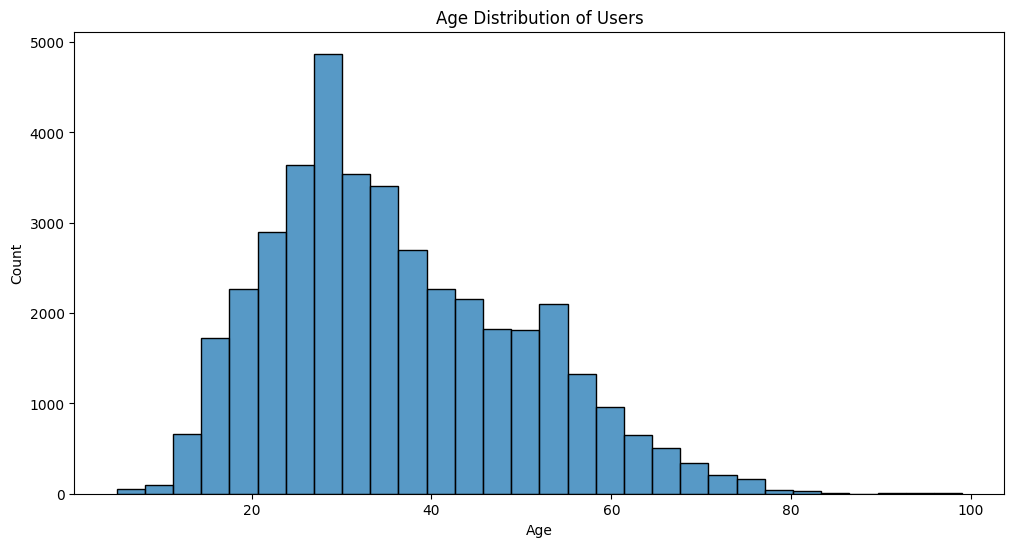

In [8]:
# 1. 나이 분포 분석
plt.figure(figsize=(12, 6))
sns.histplot(data=users_df[users_df['age'].notna()], x='age', bins=30)
plt.title('Age Distribution of Users')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

20세 미만과 80세 이상은 매우 적음

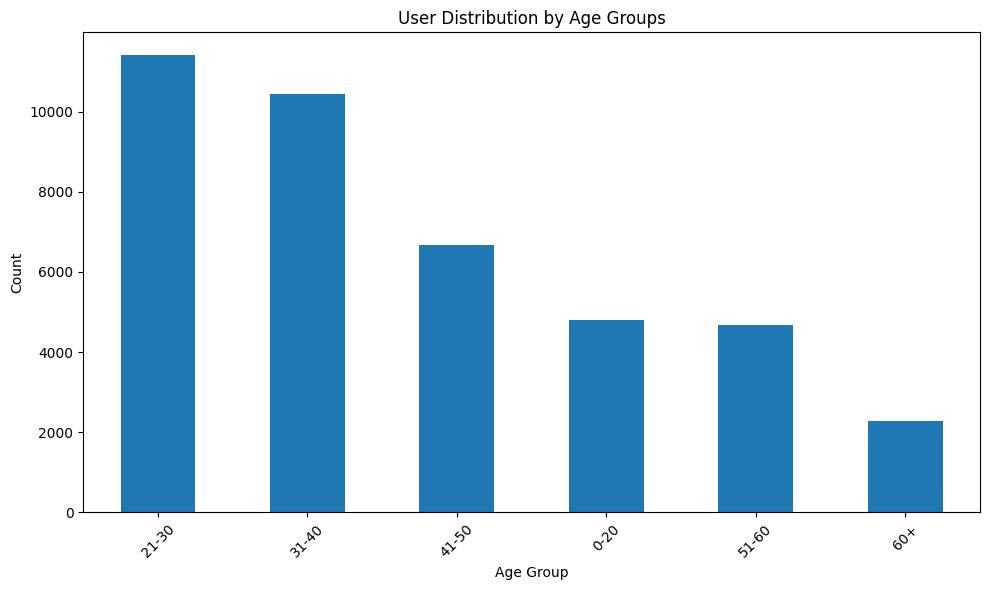

In [9]:
# 나이 그룹별 분석
users_df['age_group'] = pd.cut(users_df['age'], 
                              bins=[0, 20, 30, 40, 50, 60, 100],
                              labels=['0-20', '21-30', '31-40', '41-50', '51-60', '60+'])

plt.figure(figsize=(10, 6))
users_df['age_group'].value_counts().plot(kind='bar')
plt.title('User Distribution by Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

20-40대가 전체의 약 50% 이상 차지  
60세 이상은 매우 적음 (~2,000명)

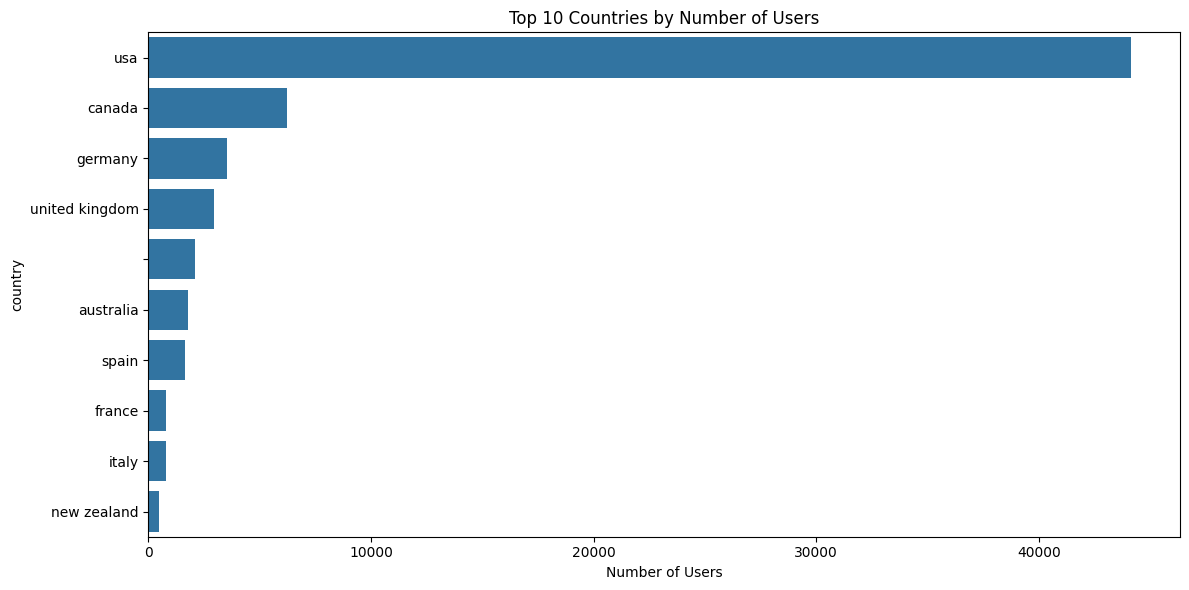

In [10]:
# 국가별 분포
users_df['country'] = users_df['location'].str.split(',').str[-1].str.strip()

plt.figure(figsize=(12, 6))
top_countries = users_df['country'].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 10 Countries by Number of Users')
plt.xlabel('Number of Users')
plt.tight_layout()
plt.show()

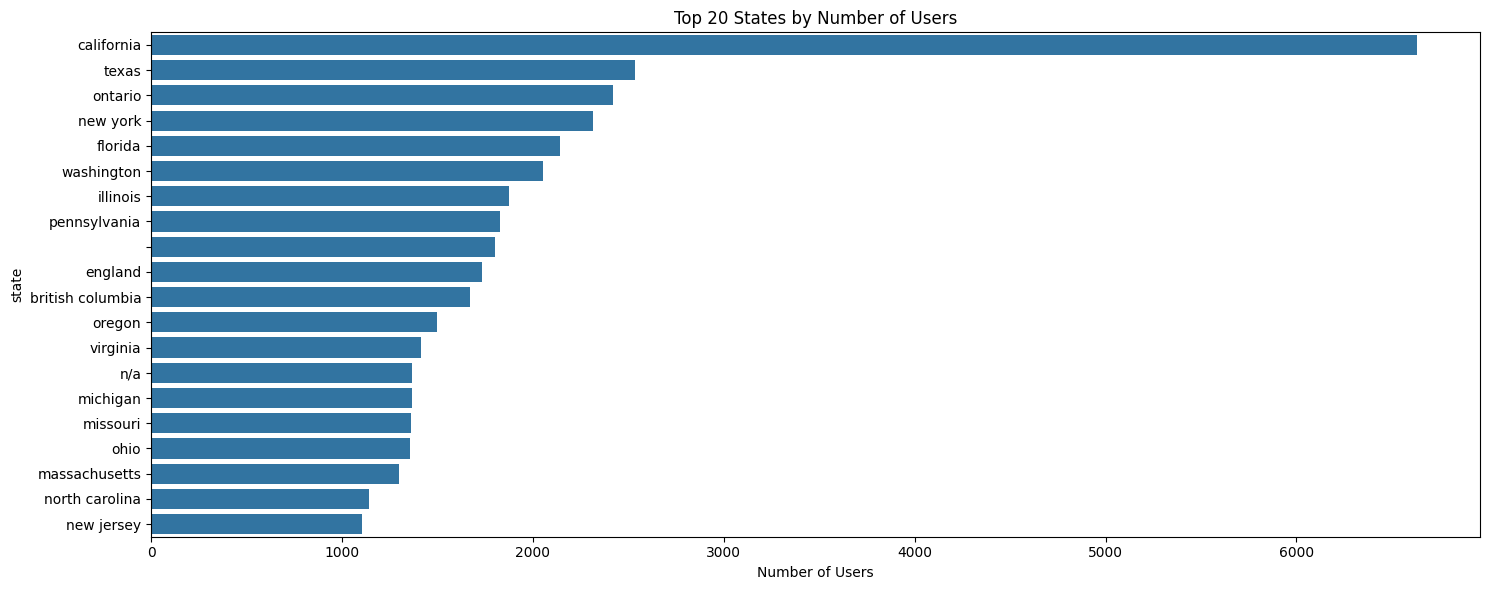

In [41]:
# 도시별 분포 (상위 20개 state)
users_df['state'] = users_df['location'].str.split(',').str[1].str.strip()

plt.figure(figsize=(15, 6))
top_cities = users_df['state'].value_counts().head(20)
sns.barplot(x=top_cities.values, y=top_cities.index)
plt.title('Top 20 States by Number of Users')
plt.xlabel('Number of Users')
plt.tight_layout()
plt.show()

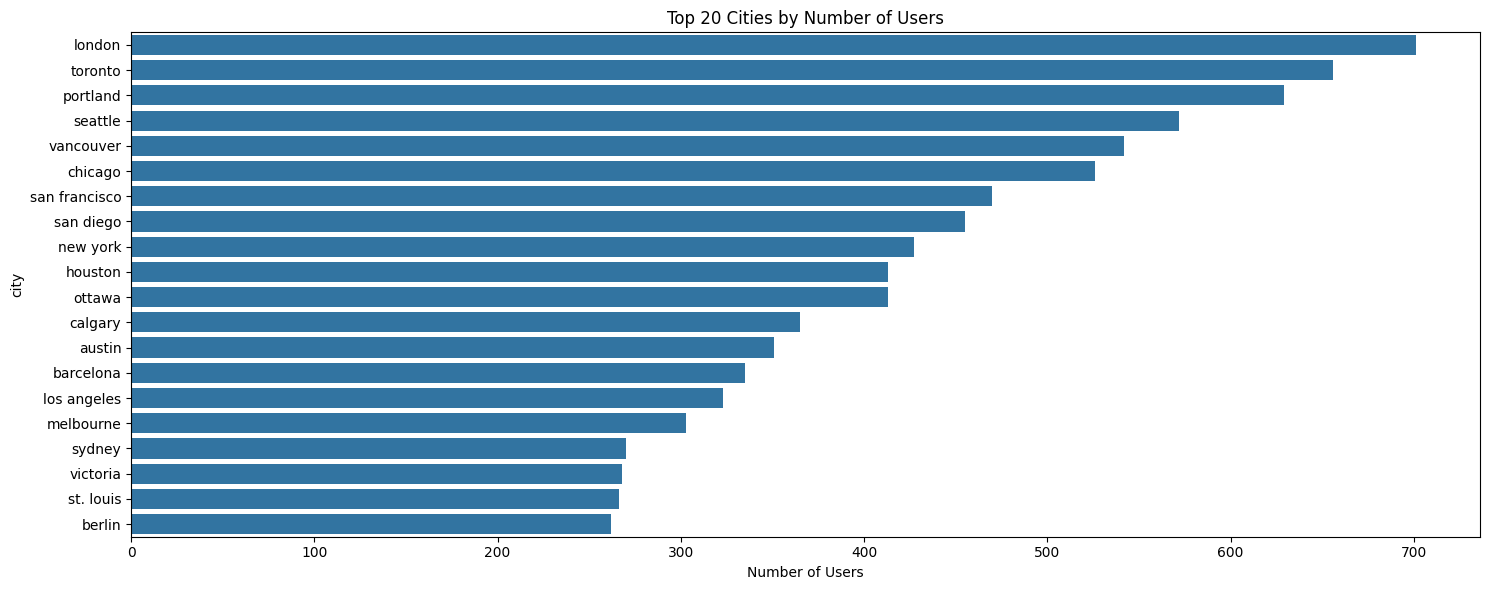

In [11]:
# 도시별 분포 (상위 20개 도시)
users_df['city'] = users_df['location'].str.split(',').str[0].str.strip()

plt.figure(figsize=(15, 6))
top_cities = users_df['city'].value_counts().head(20)
sns.barplot(x=top_cities.values, y=top_cities.index)
plt.title('Top 20 Cities by Number of Users')
plt.xlabel('Number of Users')
plt.tight_layout()
plt.show()

state랑 city는 굳이 쓸 필요가 있을까? 너무 세분화되서 안쓰는게 나을거 같기도하고

In [12]:
# 국가별 평균 평점과 사용자 수 관계 분석
country_stats = pd.merge(users_df, train_ratings_df, on='user_id')
country_analysis = country_stats.groupby('country').agg({
    'user_id': 'count',  # 사용자 수
    'rating': ['mean', 'std']  # 평균 평점과 표준편차
}).round(2)

# 상위 10개국 분석 결과
print(country_analysis.sort_values(('user_id', 'count'), ascending=False).head(10))

               user_id rating      
                 count   mean   std
country                            
usa             209702   7.12  2.44
canada           28406   6.94  2.39
united kingdom   11826   7.17  2.34
germany           9730   6.80  2.65
                  8443   6.86  2.50
spain             5774   6.72  2.32
australia         5603   6.94  2.25
n/a               5531   6.78  2.61
france            3700   7.08  2.28
portugal          2763   7.35  2.00


/tmp/ipykernel_345018/4096505961.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_345018/4096505961.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_345018/4096505961.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x=top10[('rating', 'mean')][i],


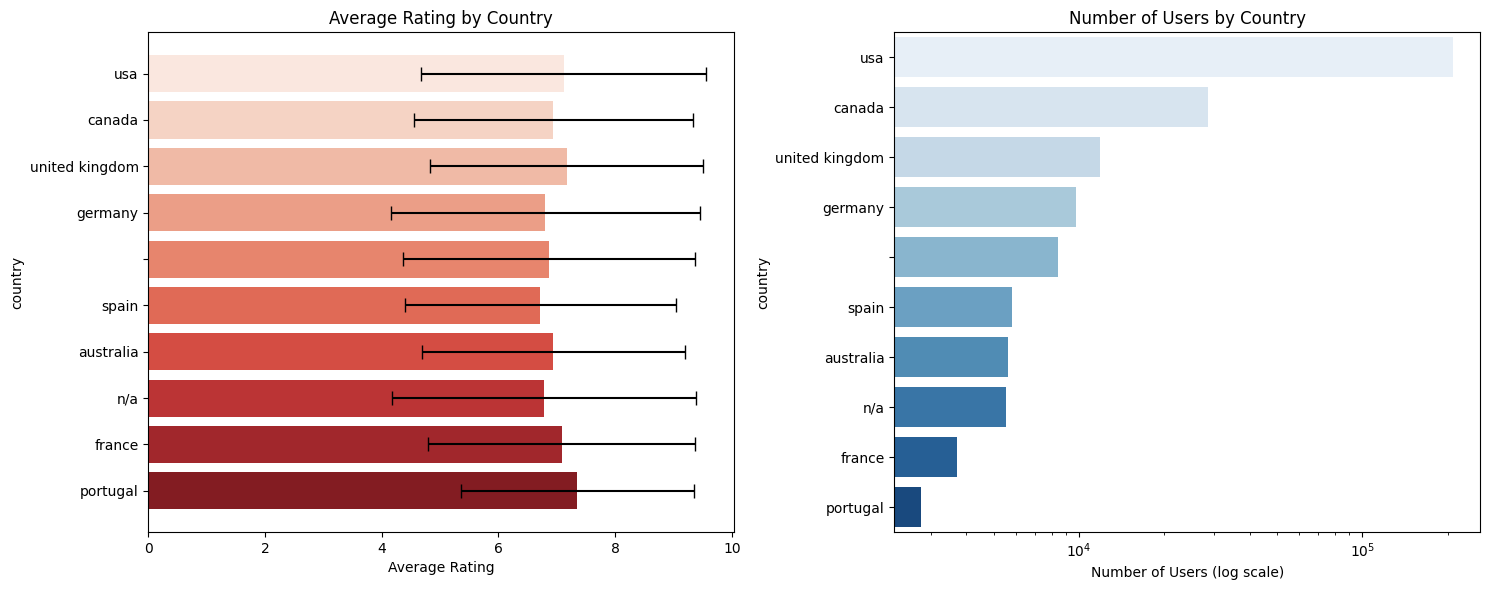

In [43]:
def visualize_country_analysis(country_analysis):
    # 상위 10개국 선택
    top10 = country_analysis.sort_values(('user_id', 'count'), ascending=False).head(10)
    
    # 서브플롯 생성
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. 평균 평점
    sns.barplot(
        x=top10[('rating', 'mean')],
        y=top10.index,
        ax=ax1,
        palette='Reds'  # YlOrRd → Reds
    )
    ax1.set_title('Average Rating by Country')
    ax1.set_xlabel('Average Rating')
    
    # 2. 사용자 수 (로그 스케일)
    sns.barplot(
        x=top10[('user_id', 'count')],
        y=top10.index,
        ax=ax2,
        palette='Blues'  # YlOrBu → Blues
    )
    ax2.set_title('Number of Users by Country')
    ax2.set_xlabel('Number of Users (log scale)')
    ax2.set_xscale('log')
    
    # 에러바 추가 (표준편차)
    for i, std in enumerate(top10[('rating', 'std')]):
        ax1.errorbar(
            x=top10[('rating', 'mean')][i],
            y=i,
            xerr=std,
            color='black',
            capsize=5
        )
    
    plt.tight_layout()
    plt.show()

visualize_country_analysis(country_analysis)

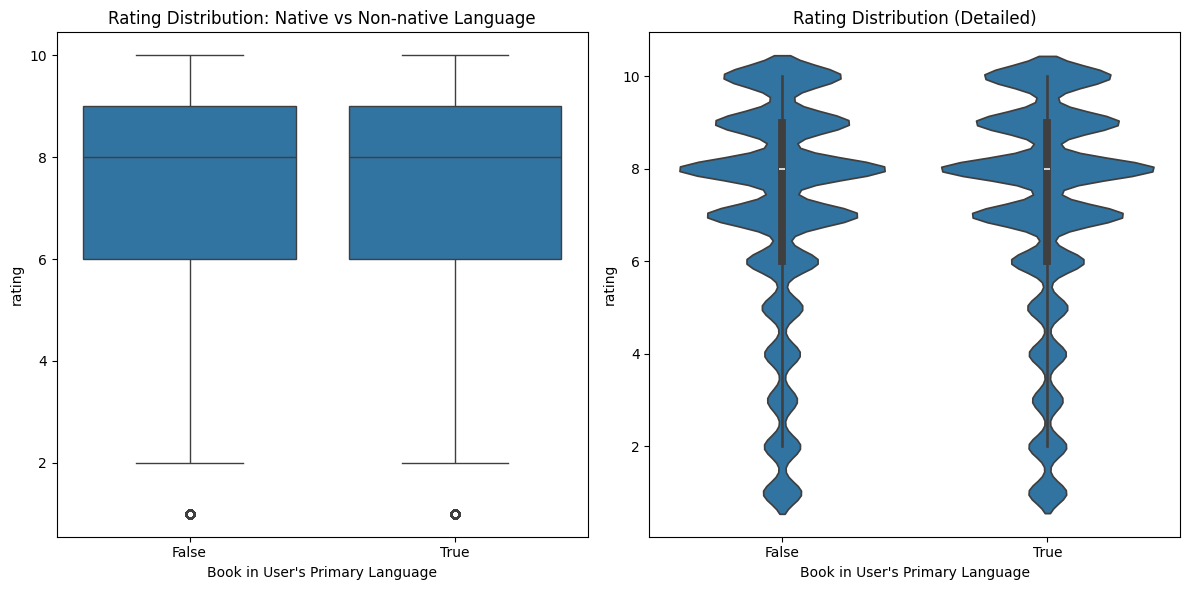


Rating Statistics:
                mean    std   count
same_language                      
False          7.047  2.434  141035
True           7.089  2.432  165760


In [46]:
def analyze_language_preference(users_df, books_df, ratings_df):
   # 사용자 국가와 언어 매핑
   country_lang_map = {
       'usa': 'en',
       'canada': 'en',  
       'united kingdom': 'en',
       'australia': 'en',
       'germany': 'de',
       'spain': 'es', 
       'france': 'fr',
       'italy': 'it',
       'portugal': 'pt'
   }
   
   # 사용자 국가 추출 및 소문자 변환
   users_df['user_country'] = users_df['location'].str.split(',').str[-1].str.strip().str.lower()
   
   # 데이터 병합
   merged_df = ratings_df.merge(users_df[['user_id', 'user_country']], on='user_id')
   merged_df = merged_df.merge(books_df[['isbn', 'language']], on='isbn')
   
   # 사용자 국가의 주요 언어와 책 언어가 일치하는지 확인
   merged_df['user_language'] = merged_df['user_country'].map(country_lang_map)
   merged_df['same_language'] = (merged_df['user_language'] == merged_df['language'])
   
   # 시각화
   plt.figure(figsize=(12, 6))
   
   plt.subplot(1, 2, 1)
   sns.boxplot(x='same_language', y='rating', data=merged_df)
   plt.title('Rating Distribution: Native vs Non-native Language')
   plt.xlabel('Book in User\'s Primary Language')
   
   plt.subplot(1, 2, 2)
   sns.violinplot(x='same_language', y='rating', data=merged_df)
   plt.title('Rating Distribution (Detailed)')
   plt.xlabel('Book in User\'s Primary Language')
   
   plt.tight_layout()
   plt.show()
   
   stats = merged_df.groupby('same_language')['rating'].agg(['mean', 'std', 'count']).round(3)
   print("\nRating Statistics:")
   print(stats)
   
   return merged_df

# 분석 실행
language_preference = analyze_language_preference(users_df, books_df, train_ratings_df)

언어가 같고 다르고는 평점에 영향이 별로 없음. 대부분 영어 데이터라 그런것 같기도? 얘도 빼도 될것 같음

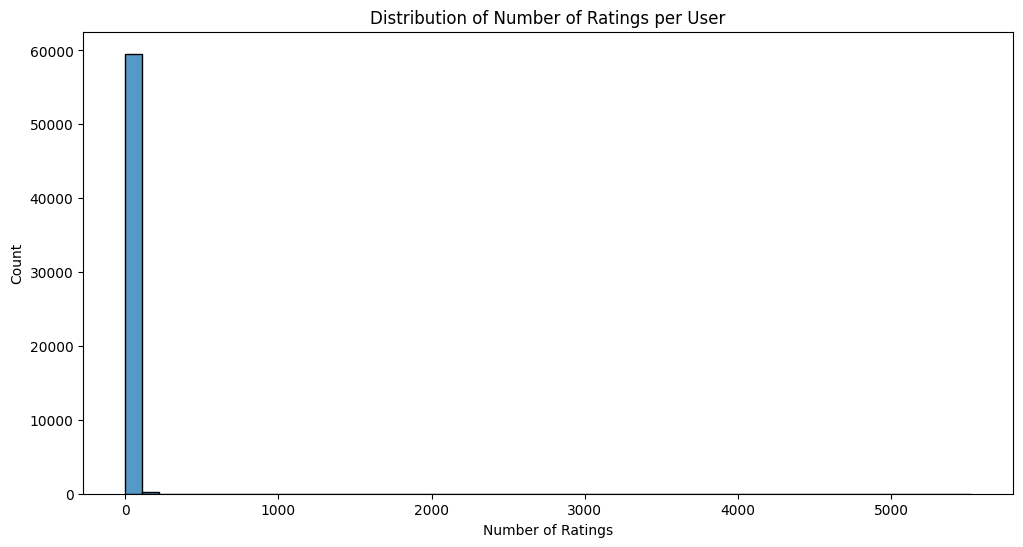

In [ ]:
# 유저별 평균 평점
user_rating_stats = train_ratings_df.groupby('user_id').agg({
    'rating': ['count', 'mean', 'std']
}).reset_index()
user_rating_stats.columns = ['user_id', 'rating_count', 'rating_mean', 'rating_std']

# 각 사용자가 몇 개의 평점을 남겼는지 분포
plt.figure(figsize=(12, 6))
sns.histplot(data=user_rating_stats, x='rating_count', bins=50)
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.show()

대부분의 사용자(약 60,000명)가 매우 적은 수의 평점을 남김  
일부 사용자는 수천 개의 평점을 남김  

너무 적은 평점을 남긴 사용자는 제외하거나 별도 처리 필요  
최소 평점 개수 기준을 설정하는 것이 좋을 듯 (예: 5개 이상)  

많은 평점을 남긴 사용자의 데이터에 더 높은 가중치 부여 고려  
단, 극단적으로 많은 평점을 남긴 사용자는 별도 검토 필요  

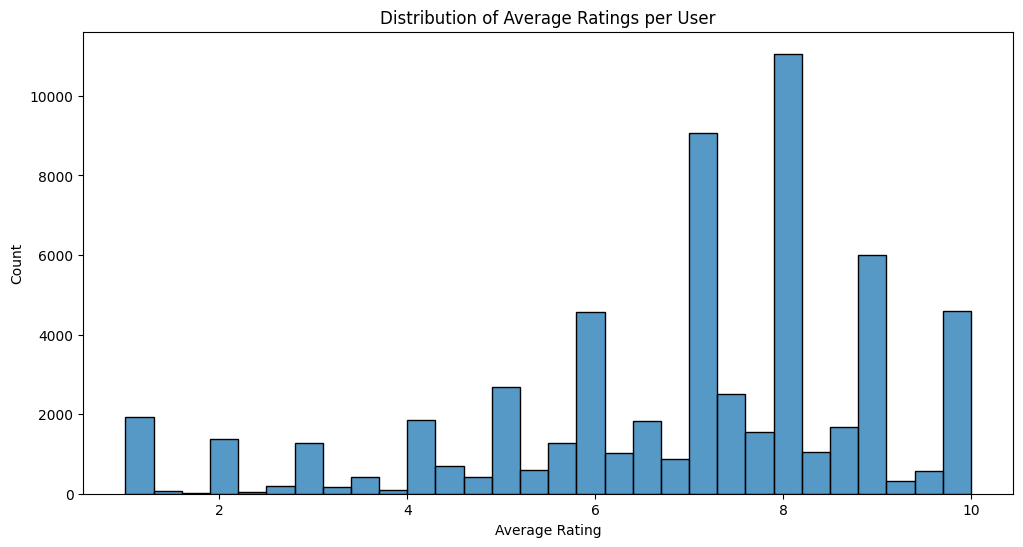

In [15]:
# 평균 평점 분포
plt.figure(figsize=(12, 6))
sns.histplot(data=user_rating_stats, x='rating_mean', bins=30)
plt.title('Distribution of Average Ratings per User')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()

사용자의 평균 평점이므로 정수가 아님

7-8점대에서 가장 높은 빈도  
약간 왼쪽으로 치우친(left-skewed) 분포  

대부분의 사용자가 평균적으로 긍정적인 평가(7-8점)를 하는 경향  

애매하게 낮은 평점(2~4)보다 1이 더 많음.   
평균 평점인데 그렇다는 건 1점은 여러 개 평가가 아닌 1개만 평가했을 가능성이 높음 

전반적으로 높은 평점 경향이 있으므로 이를 고려한 모델링 필요

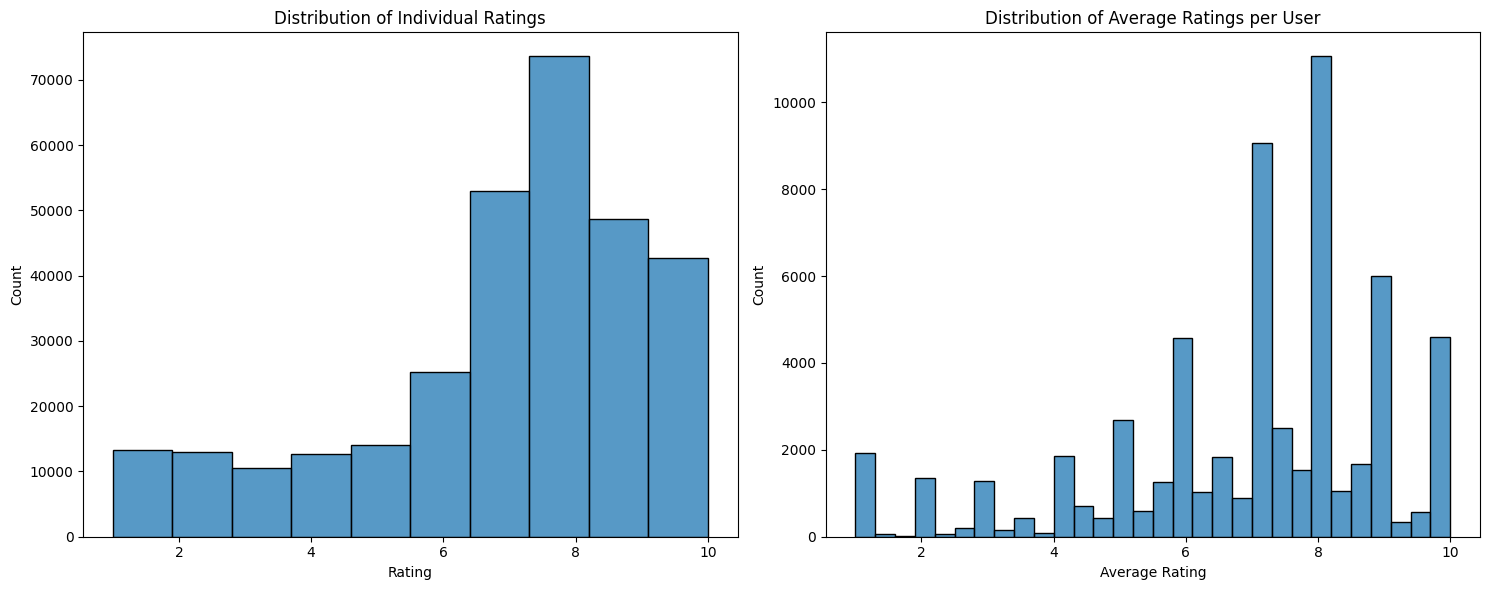

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 개별 평점 분포
sns.histplot(data=train_ratings_df, x='rating', bins=10, ax=ax1)
ax1.set_title('Distribution of Individual Ratings')
ax1.set_xlabel('Rating')

# 사용자별 평균 평점 분포
sns.histplot(data=user_rating_stats, x='rating_mean', bins=30, ax=ax2)
ax2.set_title('Distribution of Average Ratings per User')
ax2.set_xlabel('Average Rating')

plt.tight_layout()
plt.show()

왼쪽은 train데이터의 각각 모든 평점

오른쪽은 유저의 평균 평점 분포 

어느정도 비슷함

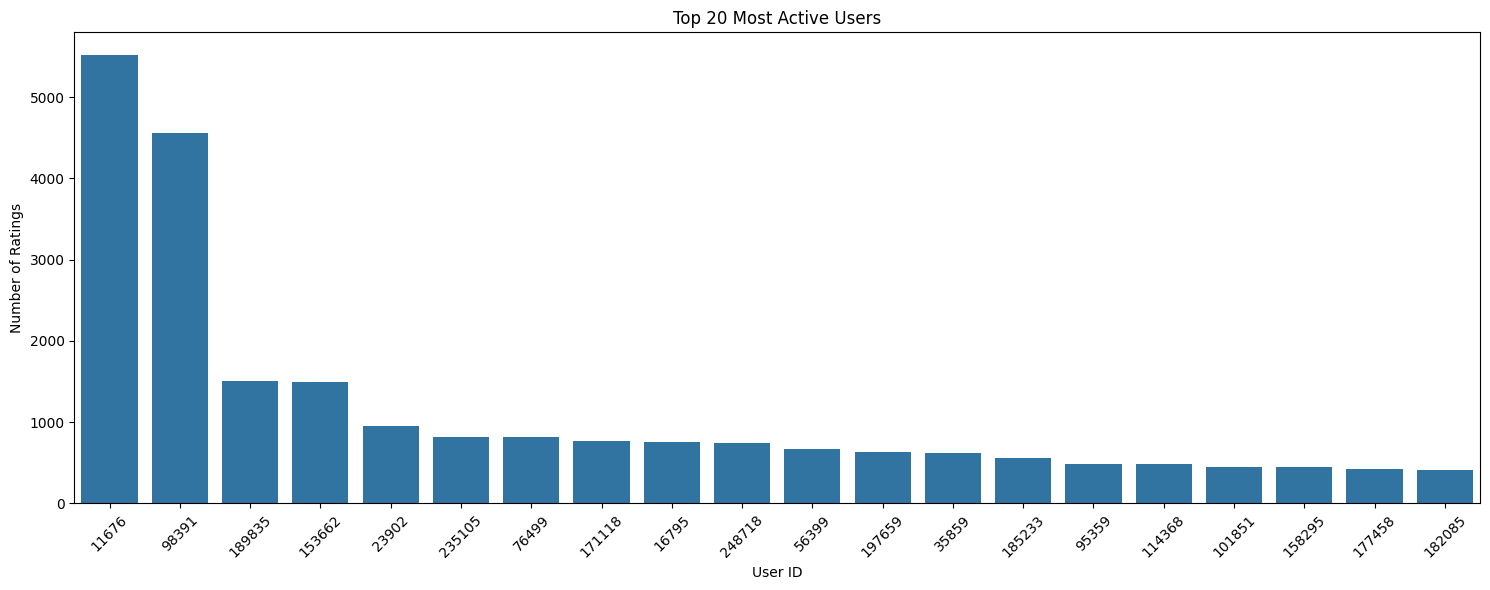

In [50]:
# 평점을 많이 준 사용자 확인 (상위 20명, 내림차순 정렬)
plt.figure(figsize=(15, 6))
top_users = user_rating_stats.nlargest(20, 'rating_count')

# x축 순서 지정을 위한 user_id 리스트 생성 (rating_count 기준 내림차순)
user_order = top_users.sort_values('rating_count', ascending=False)['user_id']

sns.barplot(data=top_users, x='user_id', y='rating_count', order=user_order)
plt.title('Top 20 Most Active Users')
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

비정상적으로 많은 평점(예: user_id 11676이 5000개 이상)을 준 사용자 확인

봇이나 비정상적인 사용 패턴으로 판단하고 제거할지

그냥 책을 좋아하는 사람인지 판단해서 가중치를 줄지 결정해야할듯

total_users: 59,803
users_with_1: 34,617 (57.9%)
users_5_or_less: 50,817 (85.0%)


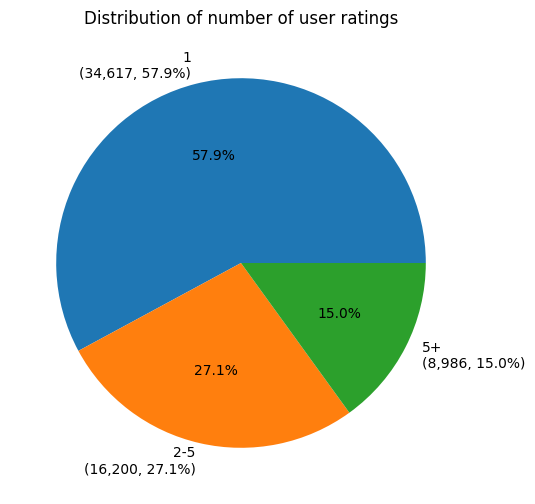

In [56]:
# 평점 수별 사용자 분포 분석
total_users = len(user_rating_stats)

# 1개 이하 평점
users_with_1 = len(user_rating_stats[user_rating_stats['rating_count'] <= 1])
ratio_1_or_less = (users_with_1 / total_users) * 100

# 5개 이하 평점
users_5_or_less = len(user_rating_stats[user_rating_stats['rating_count'] <= 5])
ratio_5_or_less = (users_5_or_less / total_users) * 100

print(f"total_users: {total_users:,}")
print(f"users_with_1: {users_with_1:,} ({ratio_1_or_less:.1f}%)")
print(f"users_5_or_less: {users_5_or_less:,} ({ratio_5_or_less:.1f}%)")

# 시각화
plt.figure(figsize=(10, 6))
rating_counts = [
   ('1', users_with_1),
   ('2-5', users_5_or_less - users_with_1),
   ('5+', total_users - users_5_or_less)
]

labels = [f'{label}\n({count:,}, {(count/total_users)*100:.1f}%)' 
         for label, count in rating_counts]
values = [count for _, count in rating_counts]

plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title('Distribution of number of user ratings')
plt.show()

1개의 평점을 단 유저가 58%

5개이하의 평점을 단 유저가 85%이하

유저마다 가중치를 조금 둬야댈듯?

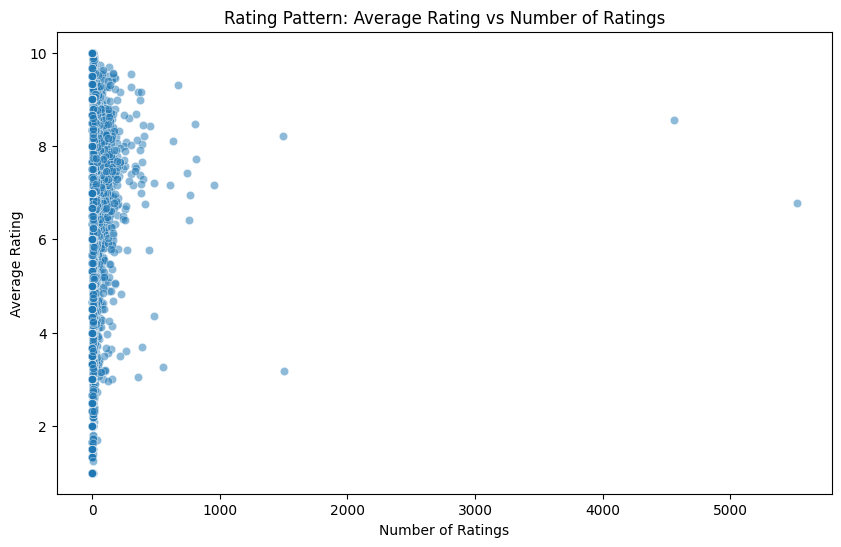

In [17]:
# 평점 패턴 산점도
plt.figure(figsize=(10, 6))
sns.scatterplot(data=user_rating_stats, x='rating_count', y='rating_mean', alpha=0.5)
plt.title('Rating Pattern: Average Rating vs Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.show()

점: 사용자

평점을 매긴 수가 많은 사용자 일수록 평균 평점이 높으려나? 해서 봤는데 딱히 그렇진 않음

극단적인 평균 평점은 대부분 평점 수가 적은 경우 이다. 이 정도만 알 수 있는 듯 

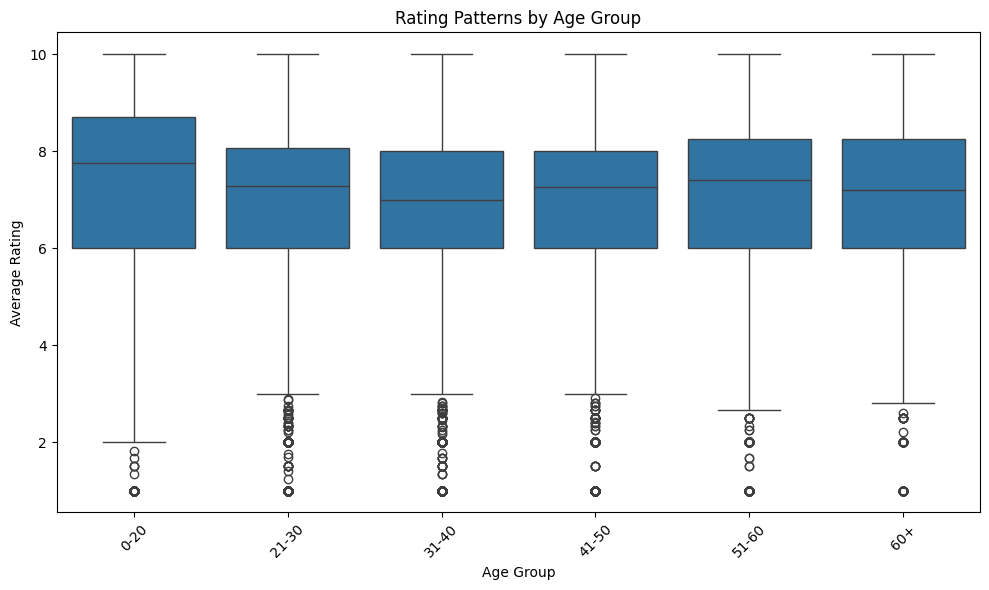

In [18]:
# 나이그룹별 평점 패턴
merged_df = pd.merge(user_rating_stats, users_df[['user_id', 'age_group']], on='user_id')

plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='age_group', y='rating_mean')
plt.title('Rating Patterns by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

나이는 평점 패턴에서 딱히 유의미한 패턴이 보이지 않음. 

얘도 제외하는게 나을 것 같음

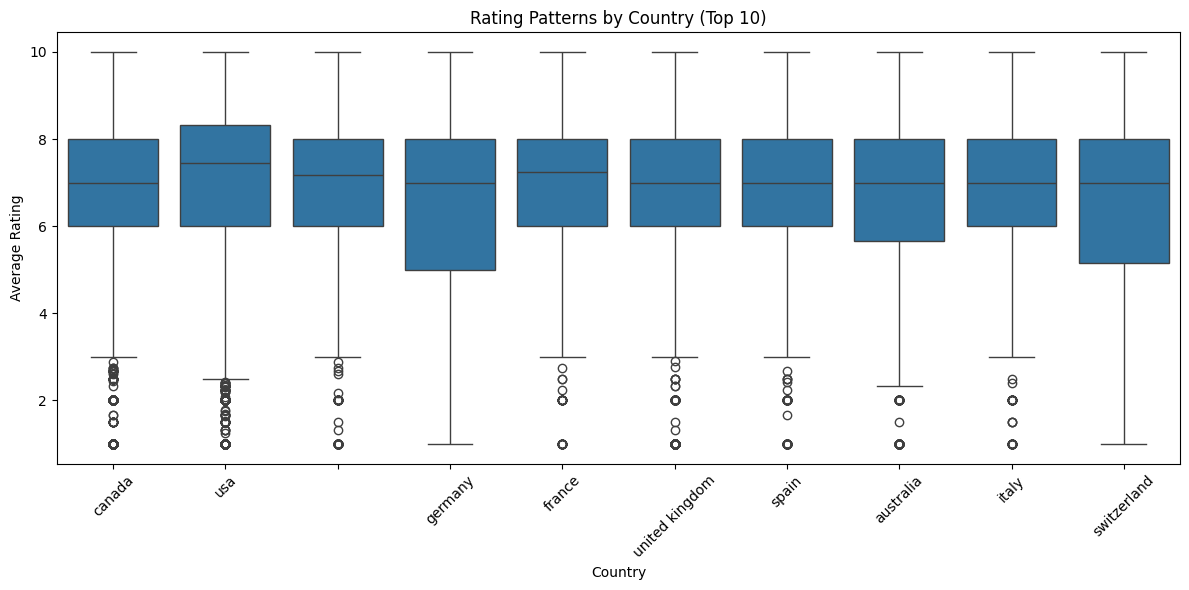

In [19]:
# 국가별 평점 패턴 (상위 10개국)
merged_df = pd.merge(user_rating_stats, users_df[['user_id', 'country']], on='user_id')
top_10_countries = merged_df['country'].value_counts().head(10).index

plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df[merged_df['country'].isin(top_10_countries)], 
            x='country', y='rating_mean')
plt.title('Rating Patterns by Country (Top 10)')
plt.xlabel('Country')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

국가도 딱히 패턴에 따라 feature로 사용하기 어려울 것 같음

# 도서 분석

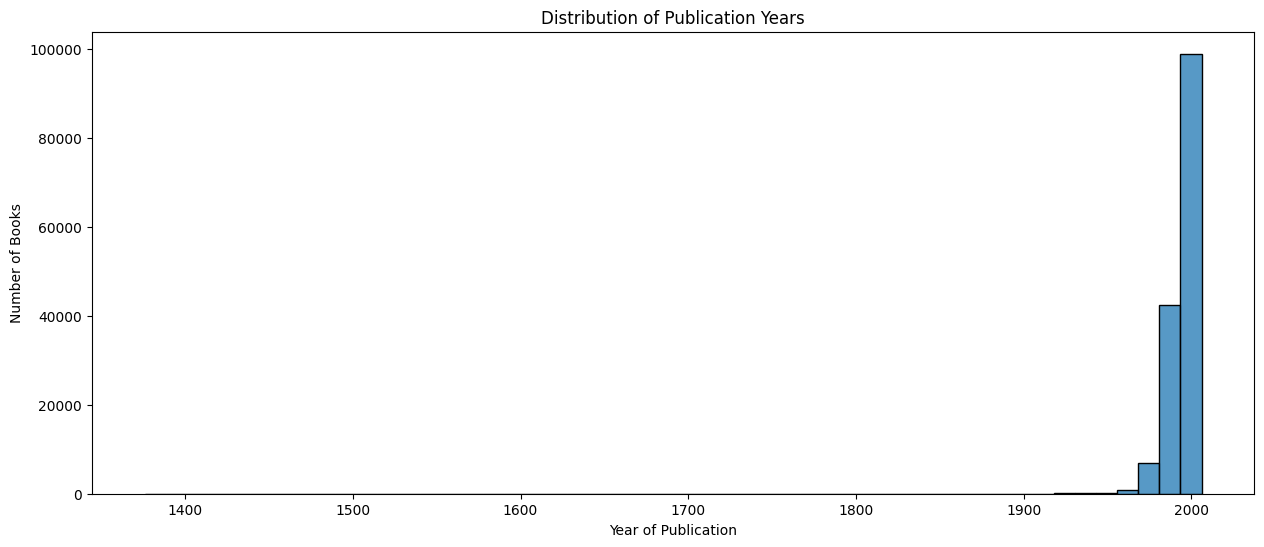

In [20]:
# 1. 출판년도 분석
plt.figure(figsize=(15, 6))
sns.histplot(data=books_df, x='year_of_publication', bins=50)
plt.title('Distribution of Publication Years')
plt.xlabel('Year of Publication')
plt.ylabel('Number of Books')
plt.show()

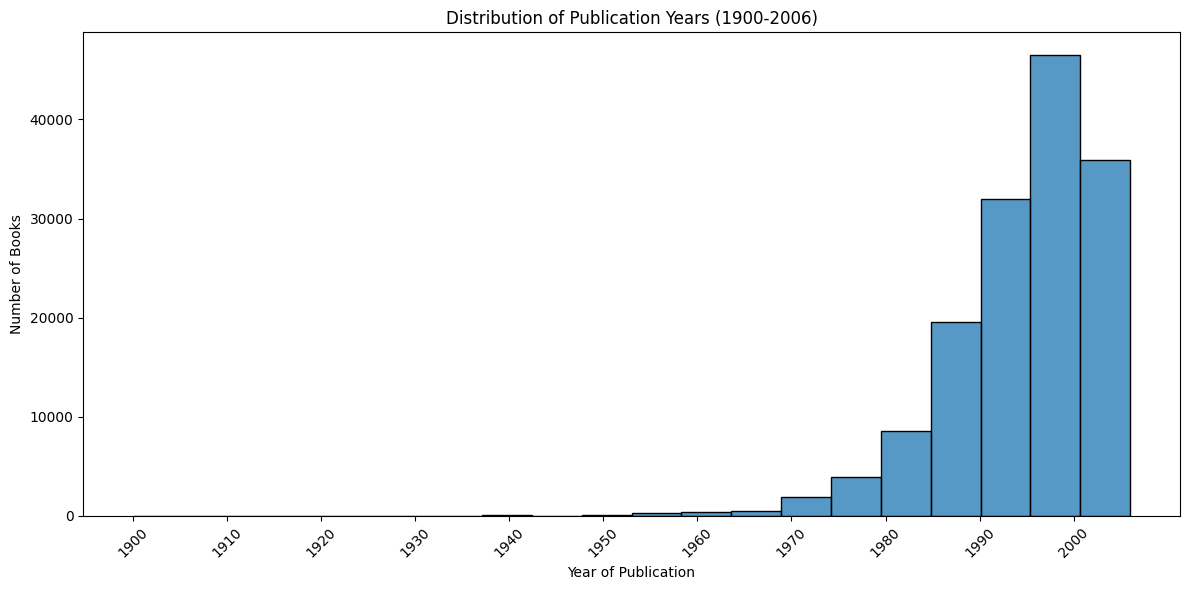

Publication Year Statistics:
Earliest year: 1900.0
Latest year: 2006.0
Most common year: 2002.0


In [57]:
# 출판년도 이상치 제거 및 분석
plt.figure(figsize=(12, 6))

# 현실적인 출판연도 범위 설정 (예: 1900년 이후)
filtered_books = books_df[
    (books_df['year_of_publication'] >= 1900) & 
    (books_df['year_of_publication'] <= 2006)  # 데이터의 최신 연도
]

# 10년 단위로 빈도 표시
sns.histplot(data=filtered_books, x='year_of_publication', bins=20)
plt.title('Distribution of Publication Years (1900-2006)')
plt.xlabel('Year of Publication')
plt.ylabel('Number of Books')

# x축 눈금 조정
plt.xticks(range(1900, 2007, 10))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 기본 통계 출력
print("Publication Year Statistics:")
print(f"Earliest year: {filtered_books['year_of_publication'].min()}")
print(f"Latest year: {filtered_books['year_of_publication'].max()}")
print(f"Most common year: {filtered_books['year_of_publication'].mode().iloc[0]}")

1900년 이전 데이터는 이상치 제거 하는게 나을 것 같기도

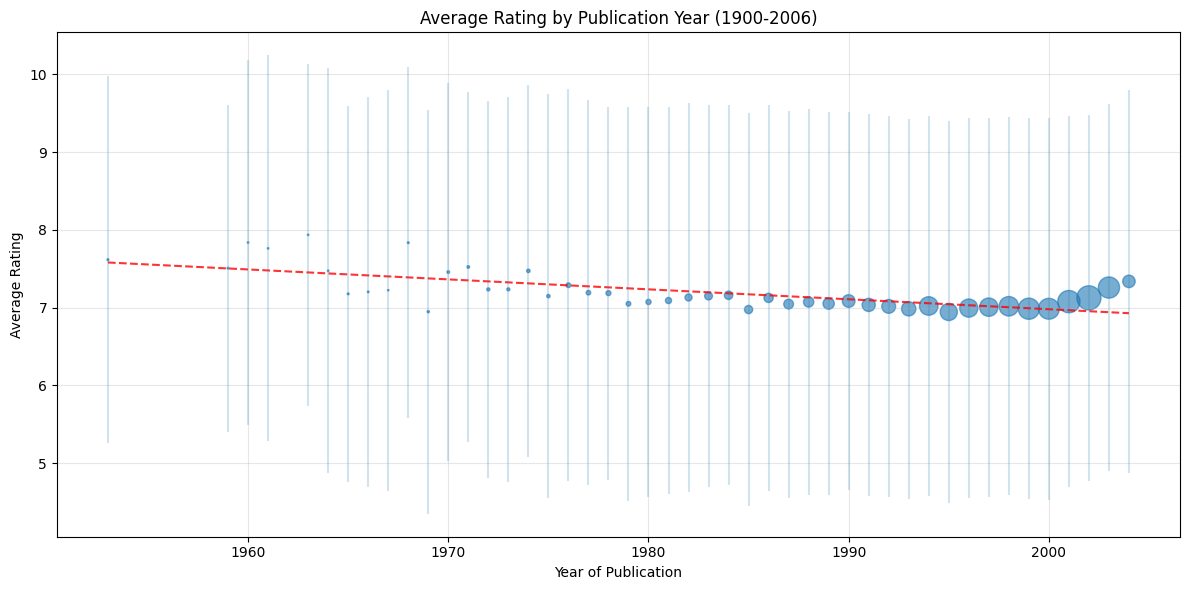


상관계수(출판연도-평균평점): -0.687


In [59]:
# 출판연도와 평점 관계 분석
# 1. 데이터 병합
merged_df = pd.merge(train_ratings_df, books_df[['isbn', 'year_of_publication']], on='isbn')

# 2. 연도별 평균 평점 계산
year_ratings = merged_df.groupby('year_of_publication').agg({
   'rating': ['mean', 'count', 'std']
}).reset_index()
year_ratings.columns = ['year', 'avg_rating', 'num_ratings', 'rating_std']

# 3. 의미 있는 데이터만 필터링 (1900년 이후, 최소 평점 수 기준)
filtered_years = year_ratings[
   (year_ratings['year'] >= 1900) & 
   (year_ratings['year'] <= 2006) &
   (year_ratings['num_ratings'] >= 100)  # 최소 평점 수 기준
]

# 4. 시각화
plt.figure(figsize=(12, 6))

# 메인 플롯: 평균 평점
plt.scatter(filtered_years['year'], filtered_years['avg_rating'], 
          s=filtered_years['num_ratings']/100,  # 점 크기는 평점 수에 비례
          alpha=0.6)

# 추세선 추가
z = np.polyfit(filtered_years['year'], filtered_years['avg_rating'], 1)
p = np.poly1d(z)
plt.plot(filtered_years['year'], p(filtered_years['year']), "r--", alpha=0.8)

plt.title('Average Rating by Publication Year (1900-2006)')
plt.xlabel('Year of Publication')
plt.ylabel('Average Rating')

# 에러바 추가 (표준편차)
plt.errorbar(filtered_years['year'], filtered_years['avg_rating'], 
           yerr=filtered_years['rating_std'], 
           fmt='none', alpha=0.2)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 상관계수 출력
correlation = filtered_years['year'].corr(filtered_years['avg_rating'])
print(f"\n상관계수(출판연도-평균평점): {correlation:.3f}")

최근으로 올수록 점이 커짐
= 최근 책들이 더 많은 평점을 받음

전체적으로 아주 약한 하락 추세  
-> 살아남은 책이란건 보증된 책이기 때문에 그렇지 않을까

실질적으로는 거의 평평한 선. 연도만으로는 feature에 사용하기 어려울 듯

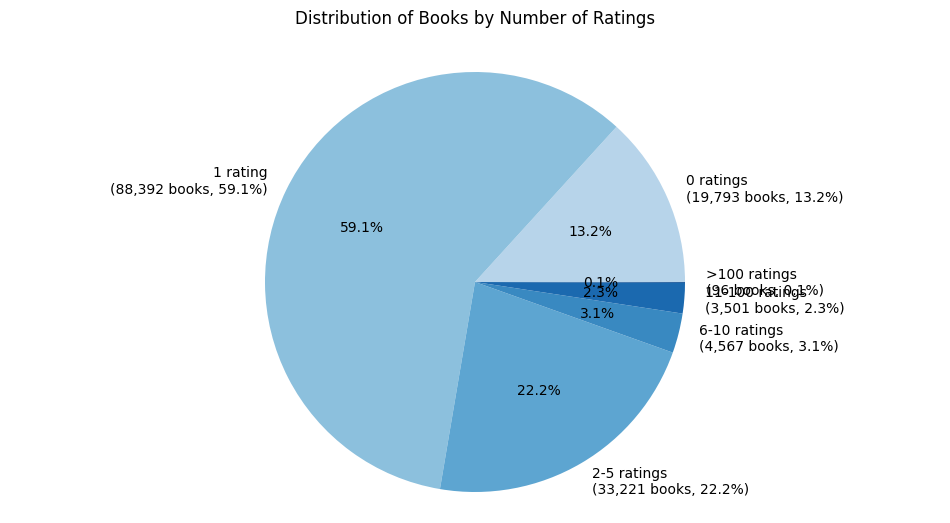


Detailed Statistics:
0 ratings: 19,793 books (13.2%)
1 rating: 88,392 books (59.1%)
2-5 ratings: 33,221 books (22.2%)
6-10 ratings: 4,567 books (3.1%)
11-100 ratings: 3,501 books (2.3%)
>100 ratings: 96 books (0.1%)


In [76]:
# 책별 평점 수 분석
book_rating_counts = train_ratings_df['isbn'].value_counts()

# 각 구간별 책 수 계산
rating_ranges = {
   '0 ratings': len(books_df[~books_df['isbn'].isin(book_rating_counts.index)]),
   '1 rating': len(book_rating_counts[book_rating_counts == 1]),
   '2-5 ratings': len(book_rating_counts[(book_rating_counts > 1) & (book_rating_counts <= 5)]),
   '6-10 ratings': len(book_rating_counts[(book_rating_counts > 5) & (book_rating_counts <= 10)]),
   '11-100 ratings': len(book_rating_counts[(book_rating_counts > 10) & (book_rating_counts <= 100)]),
   '>100 ratings': len(book_rating_counts[book_rating_counts > 100])
}

# 전체 책 수
total_books = len(books_df)

# 비율 계산 및 시각화
plt.figure(figsize=(12, 6))

# 파이 차트 생성
plt.pie([v/total_books*100 for v in rating_ranges.values()], 
       labels=[f'{k}\n({v:,} books, {v/total_books*100:.1f}%)' 
               for k, v in rating_ranges.items()],
       autopct='%1.1f%%',
       colors=plt.cm.Blues(np.linspace(0.3, 0.9, len(rating_ranges))))

plt.title('Distribution of Books by Number of Ratings', pad=20)
plt.axis('equal')
plt.show()

# 통계 출력
print("\nDetailed Statistics:")
for k, v in rating_ranges.items():
   print(f"{k}: {v:,} books ({v/total_books*100:.1f}%)")

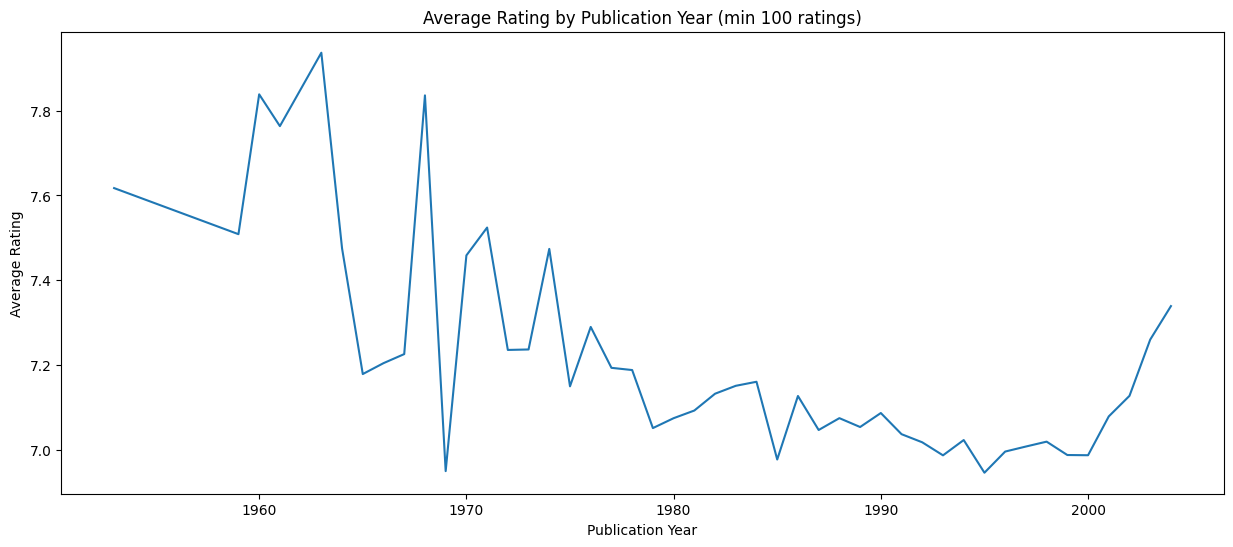

In [80]:
# 출판년도별 평균 평점
books_ratings = pd.merge(train_ratings_df, books_df[['isbn', 'year_of_publication']], on='isbn')
year_avg_ratings = books_ratings.groupby('year_of_publication')['rating'].agg(['mean', 'count']).reset_index()
year_avg_ratings = year_avg_ratings[year_avg_ratings['count'] > 100]  # 최소 100개 이상의 평점

plt.figure(figsize=(15, 6))
sns.lineplot(data=year_avg_ratings, x='year_of_publication', y='mean')
plt.title('Average Rating by Publication Year (min 100 ratings)')
plt.xlabel('Publication Year')
plt.ylabel('Average Rating')
plt.show()

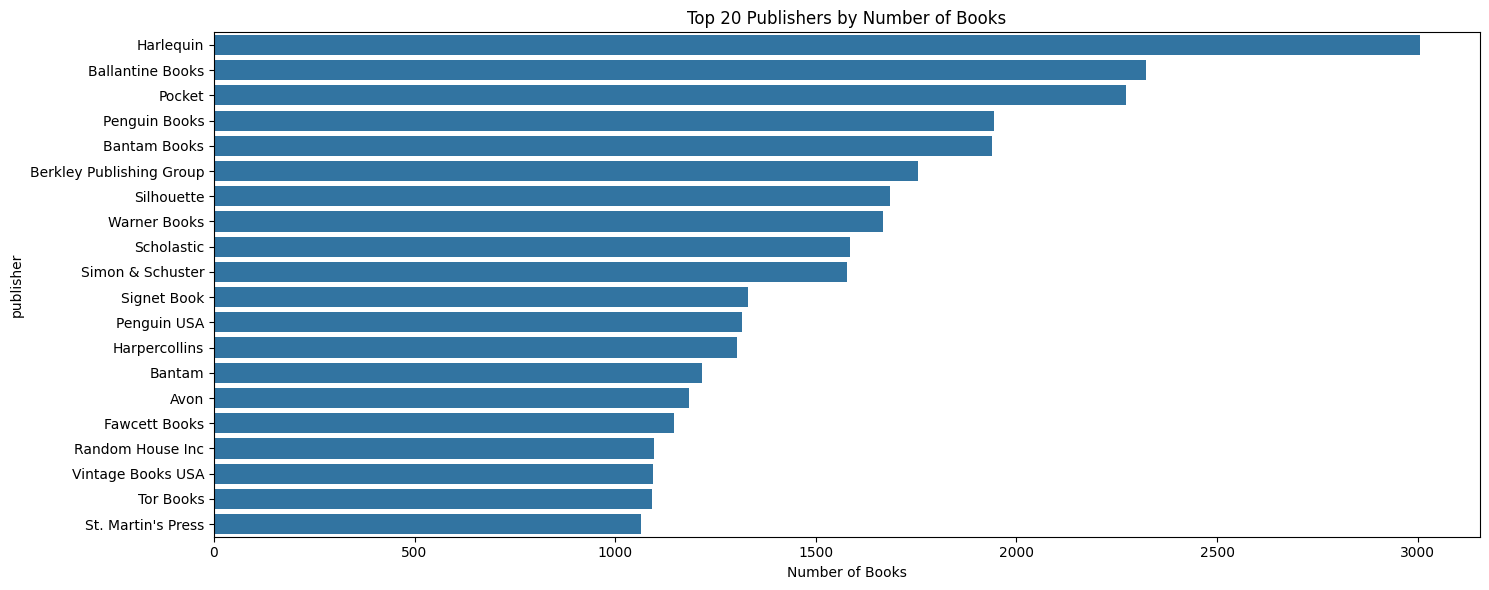

In [22]:
# 상위 20개 출판사
plt.figure(figsize=(15, 6))
top_publishers = books_df['publisher'].value_counts().head(20)
sns.barplot(x=top_publishers.values, y=top_publishers.index)
plt.title('Top 20 Publishers by Number of Books')
plt.xlabel('Number of Books')
plt.tight_layout()
plt.show()

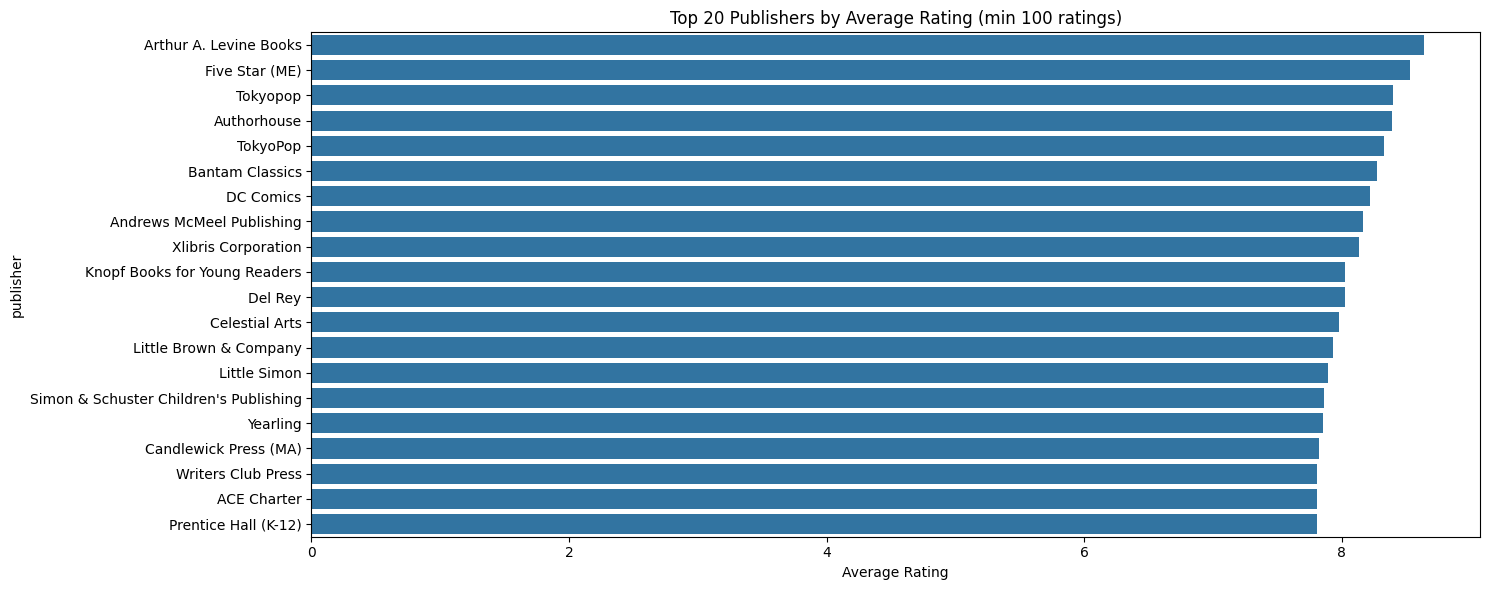

In [23]:
# 출판사별 평균 평점
publisher_ratings = pd.merge(books_df, train_ratings_df, on='isbn')
publisher_avg = publisher_ratings.groupby('publisher').agg({
    'rating': ['count', 'mean']
}).reset_index()
publisher_avg.columns = ['publisher', 'rating_count', 'rating_mean']
publisher_avg = publisher_avg[publisher_avg['rating_count'] > 100]  # 최소 100개 이상의 평점

plt.figure(figsize=(15, 6))
top_rated_publishers = publisher_avg.nlargest(20, 'rating_mean')
sns.barplot(data=top_rated_publishers, x='rating_mean', y='publisher')
plt.title('Top 20 Publishers by Average Rating (min 100 ratings)')
plt.xlabel('Average Rating')
plt.tight_layout()
plt.show()

출판사 만으로는 뭐 안 될것 같은데

In [62]:
# 모든 출판사 리스트 확인
publisher_counts = books_df['publisher'].value_counts()
print("총 출판사 수:", len(publisher_counts))
print("\n상위 50개 출판사와 각각의 도서 수:")
print(publisher_counts.head(50))

# 출판사 이름에 어떤 키워드들이 자주 등장하는지도 확인하면 좋을 것 같습니다
# 예: Books, Press, Publishing, Comics, Children's 등

# 출판사 이름 키워드 분석
common_keywords = ['books', 'press', 'publishing', 'comics', 'children', 'media', 'international']
keyword_counts = {keyword: sum(publisher_counts[publisher_counts.index.str.lower().str.contains(keyword)]) 
                 for keyword in common_keywords}

print("\n주요 키워드별 도서 수:")
for keyword, count in sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{keyword}: {count}")

총 출판사 수: 11571

상위 50개 출판사와 각각의 도서 수:
publisher
Harlequin                             3005
Ballantine Books                      2322
Pocket                                2274
Penguin Books                         1943
Bantam Books                          1938
Berkley Publishing Group              1754
Silhouette                            1684
Warner Books                          1667
Scholastic                            1586
Simon & Schuster                      1578
Signet Book                           1332
Penguin USA                           1315
Harpercollins                         1303
Bantam                                1217
Avon                                  1185
Fawcett Books                         1146
Random House Inc                      1098
Vintage Books USA                     1095
Tor Books                             1092
St. Martin's Press                    1065
Perennial                              906
HarperCollins Publishers               888
Jove B

In [63]:
def categorize_publisher(publisher):
    publisher = str(publisher).lower()
    
    # 로맨스/감성 출판사
    if any(x in publisher for x in ['harlequin', 'silhouette', 'avon', 'mira']):
        return 'Romance'
    
    # 아동/청소년 출판사
    elif any(x in publisher for x in ['scholastic', 'puffin', 'golden books', 'harpertrophy']):
        return 'Children/Young Adult'
    
    # 학술/교육 출판사
    elif any(x in publisher for x in ['oxford', 'academic', 'university press', 'education']):
        return 'Academic'
    
    # SF/판타지 전문
    elif any(x in publisher for x in ['tor books', 'del rey', 'baen']):
        return 'SF/Fantasy'
    
    # 대형 종합 출판사
    elif any(x in publisher for x in ['penguin', 'random house', 'harpercollins', 'simon & schuster', 
                                    'bantam', 'ballantine', 'berkley', 'pocket']):
        return 'Major Publisher'
    
    # 만화/그래픽노블
    elif any(x in publisher for x in ['comics', 'manga', 'tokyopop', 'viz']):
        return 'Comics/Manga'
    
    # 독일어권 출판사
    elif any(x in publisher for x in ['goldmann', 'heyne']):
        return 'German Publisher'
    
    # 프랑스어권 출판사
    elif any(x in publisher for x in ['gallimard']):
        return 'French Publisher'
    
    return 'Others'

# 적용
books_df['publisher_category'] = books_df['publisher'].apply(categorize_publisher)

# 카테고리별 통계 확인
category_stats = books_df.groupby('publisher_category').agg({
    'isbn': 'count'
}).sort_values('isbn', ascending=False)

print("Publisher Category Statistics:")
print(category_stats)

# 카테고리별 평균 평점 확인
merged_df = pd.merge(books_df, train_ratings_df, on='isbn')
category_ratings = merged_df.groupby('publisher_category').agg({
    'rating': ['count', 'mean', 'std']
}).round(2)

print("\nCategory Rating Statistics:")
print(category_ratings)

Publisher Category Statistics:
                        isbn
publisher_category          
Others                104842
Major Publisher        25347
Romance                 7174
Children/Young Adult    4234
SF/Fantasy              2740
Academic                2525
German Publisher        1463
Comics/Manga             654
French Publisher         591

Category Rating Statistics:
                      rating            
                       count  mean   std
publisher_category                      
Academic                2498  7.13  2.52
Children/Young Adult    8257  7.28  2.53
Comics/Manga             937  8.22  2.06
French Publisher         790  7.06  2.30
German Publisher        2246  6.33  2.68
Major Publisher        68621  7.05  2.39
Others                201790  7.09  2.43
Romance                14790  6.74  2.57
SF/Fantasy              6866  7.31  2.34


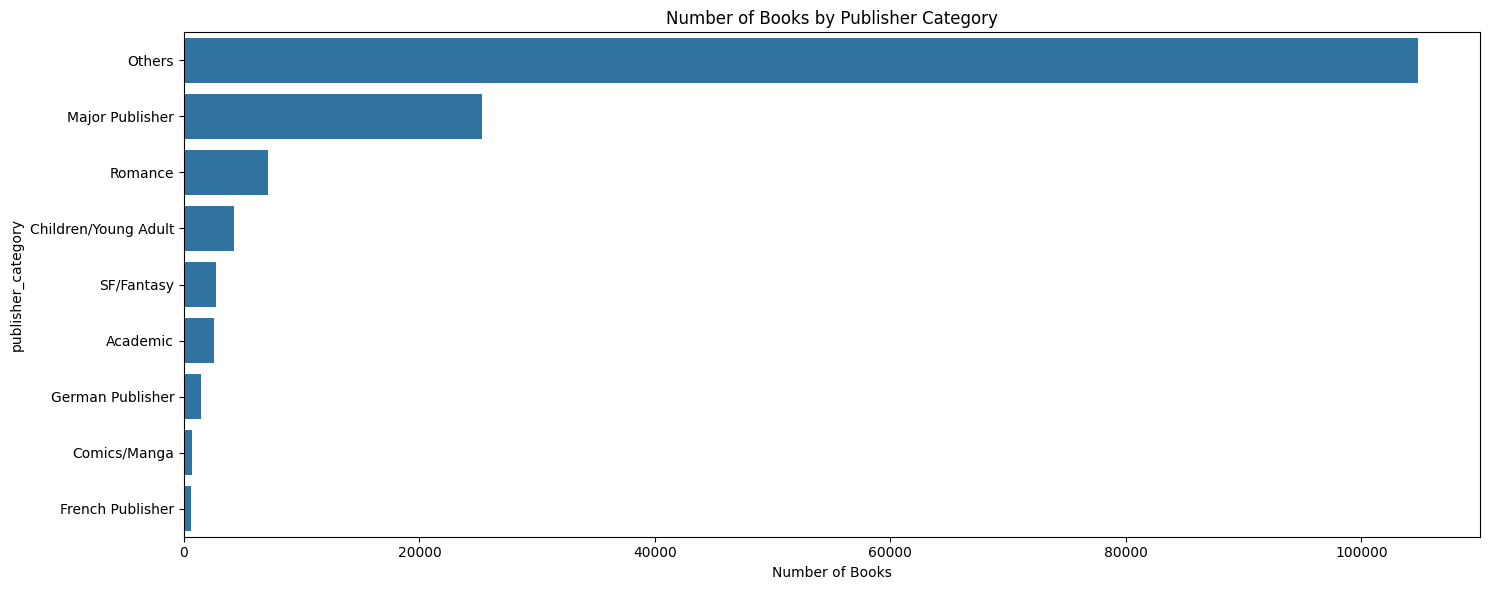

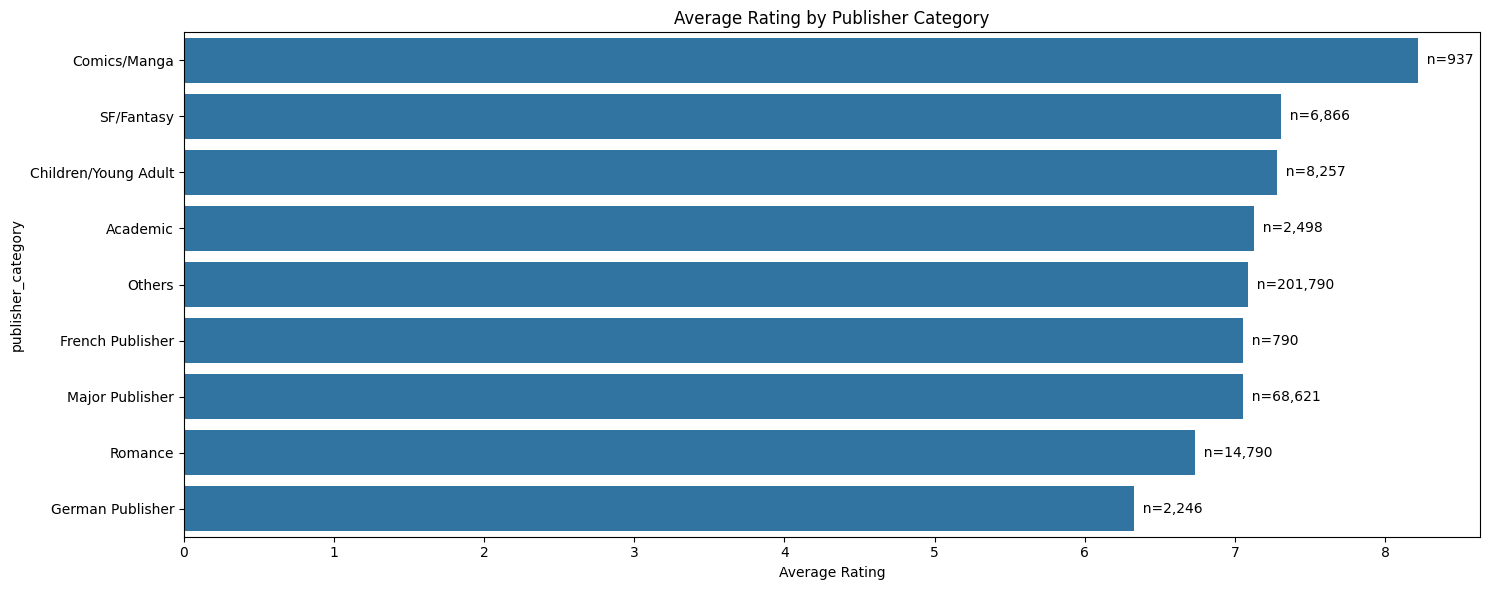

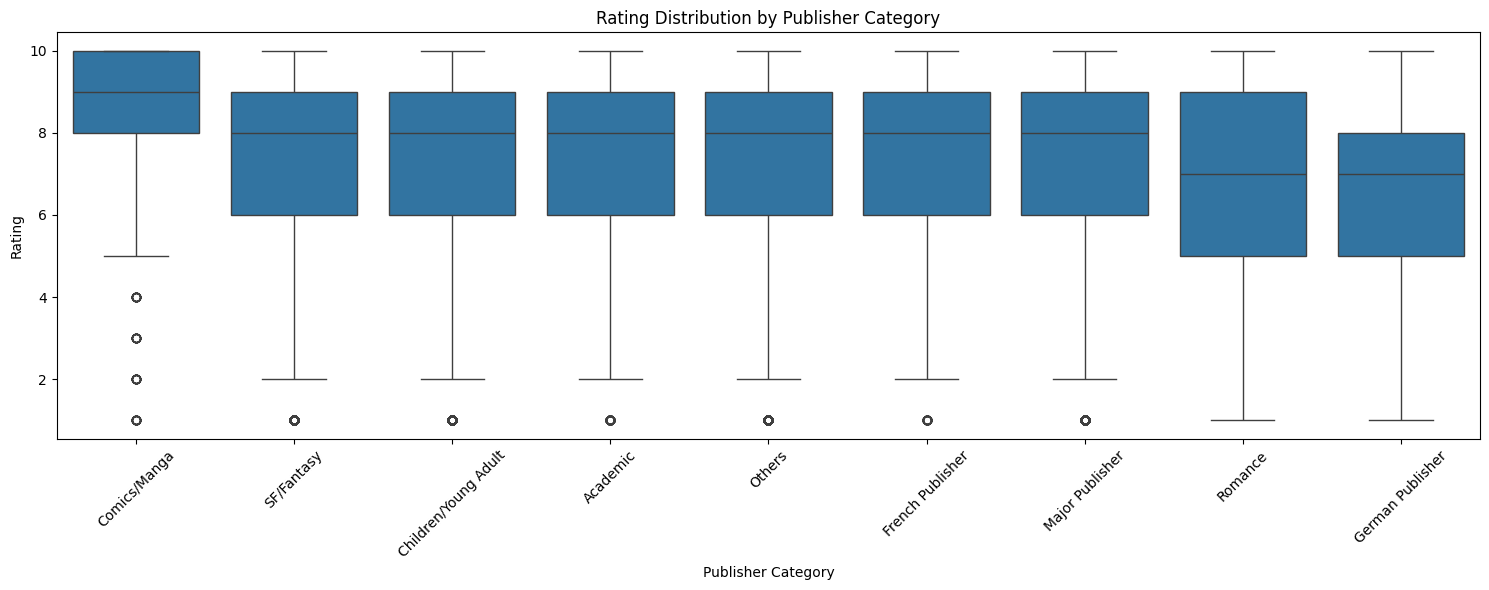

In [64]:
# 1. 카테고리별 도서 수 시각화
plt.figure(figsize=(15, 6))
category_counts = books_df['publisher_category'].value_counts()
sns.barplot(x=category_counts.values, y=category_counts.index)
plt.title('Number of Books by Publisher Category')
plt.xlabel('Number of Books')
plt.tight_layout()
plt.show()

# 2. 카테고리별 평균 평점 시각화
merged_df = pd.merge(books_df, train_ratings_df, on='isbn')
plt.figure(figsize=(15, 6))
category_ratings = merged_df.groupby('publisher_category')['rating'].mean().sort_values(ascending=False)

# 평점 수도 함께 표시하기 위해 텍스트 추가
rating_counts = merged_df.groupby('publisher_category')['rating'].count()

sns.barplot(x=category_ratings.values, y=category_ratings.index)
plt.title('Average Rating by Publisher Category')
plt.xlabel('Average Rating')

# 각 막대 끝에 평점 수 표시
for i, v in enumerate(category_ratings):
   count = rating_counts[category_ratings.index[i]]
   plt.text(v, i, f'  n={count:,}', va='center')

plt.tight_layout()
plt.show()

# 3. 카테고리별 평점 분포 시각화 (boxplot)
plt.figure(figsize=(15, 6))
sns.boxplot(data=merged_df, x='publisher_category', y='rating', 
           order=category_ratings.index)
plt.title('Rating Distribution by Publisher Category')
plt.xlabel('Publisher Category')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

아래와 같이 카테고리 가중치 적용하는 방식으로 사용가능할듯

In [ ]:
# category_weights = {
#     'Comics/Manga': 1.2,      # 높은 평점 + 일관성
#     'SF/Fantasy': 1.1,        # 높은 평점
#     'Children/Young Adult': 1.1,
#     'Others': 1.0,            # 기준
#     'Romance': 0.9,           # 낮은 평점
#     'German Publisher': 0.9
# }

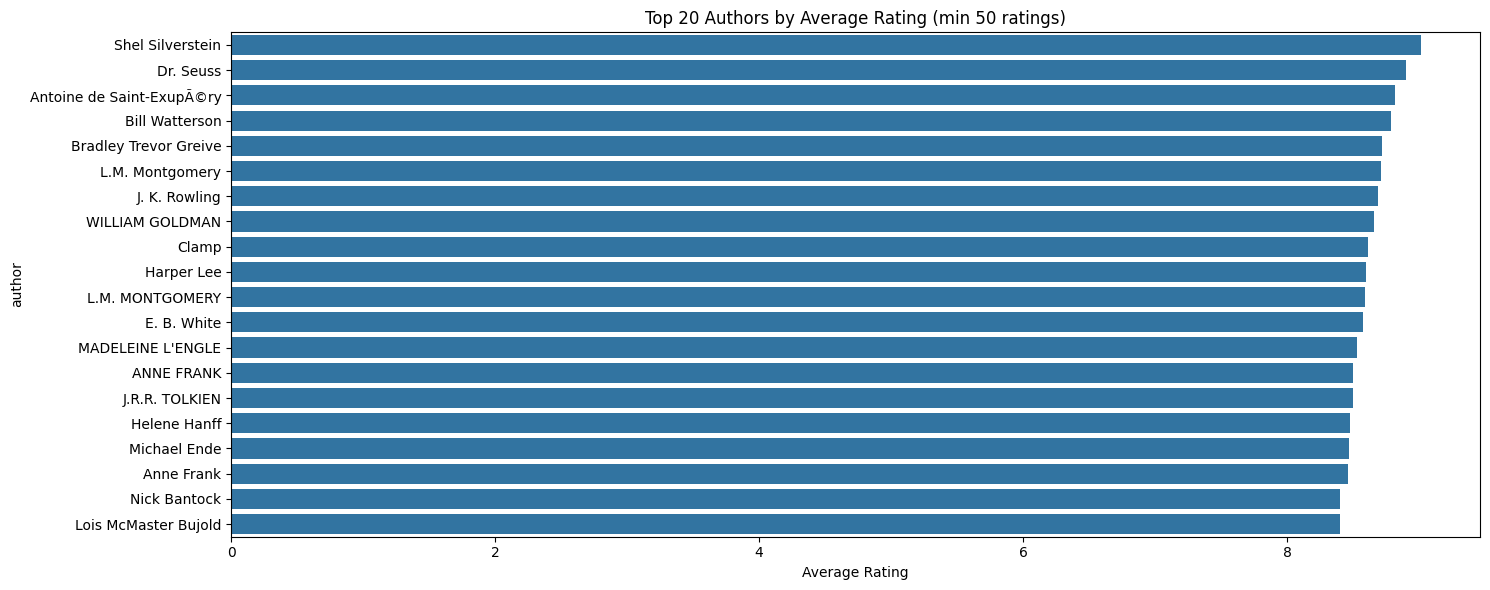

In [25]:
# 작가별 평균 평점
author_ratings = pd.merge(books_df, train_ratings_df, on='isbn')
author_avg = author_ratings.groupby('book_author').agg({
    'rating': ['count', 'mean']
}).reset_index()
author_avg.columns = ['author', 'rating_count', 'rating_mean']
author_avg = author_avg[author_avg['rating_count'] > 50]  # 최소 50개 이상의 평점

plt.figure(figsize=(15, 6))
top_rated_authors = author_avg.nlargest(20, 'rating_mean')
sns.barplot(data=top_rated_authors, x='rating_mean', y='author')
plt.title('Top 20 Authors by Average Rating (min 50 ratings)')
plt.xlabel('Average Rating')
plt.tight_layout()
plt.show()

작가는 너무 많아서 못 쓰지 않을까. 딱히 생각나는 활용방안이 안 떠오름.

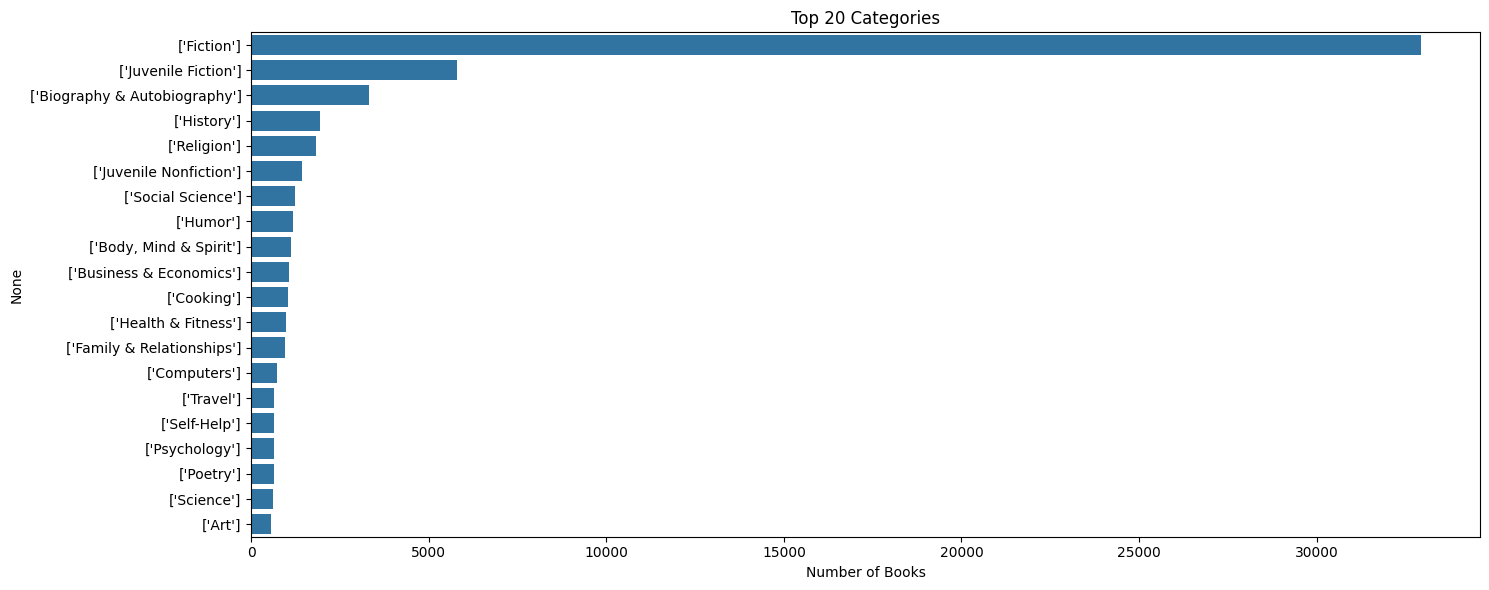

In [68]:
# 4. 카테고리 분석
# 카테고리 문자열을 리스트로 변환
def extract_categories(category_str):
    if pd.isna(category_str):
        return []
    try:
        return ast.literal_eval(category_str)
    except:
        return [category_str]

# 모든 카테고리 추출
all_categories = []
for categories in books_df['category'].dropna():
    all_categories.extend(extract_categories(categories))

# 상위 20개 카테고리
plt.figure(figsize=(15, 6))
top_categories = pd.Series(all_categories).value_counts().head(20)
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title('Top 20 Categories')
plt.xlabel('Number of Books')
plt.tight_layout()
plt.show()

/tmp/ipykernel_345018/25032221.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_categories,


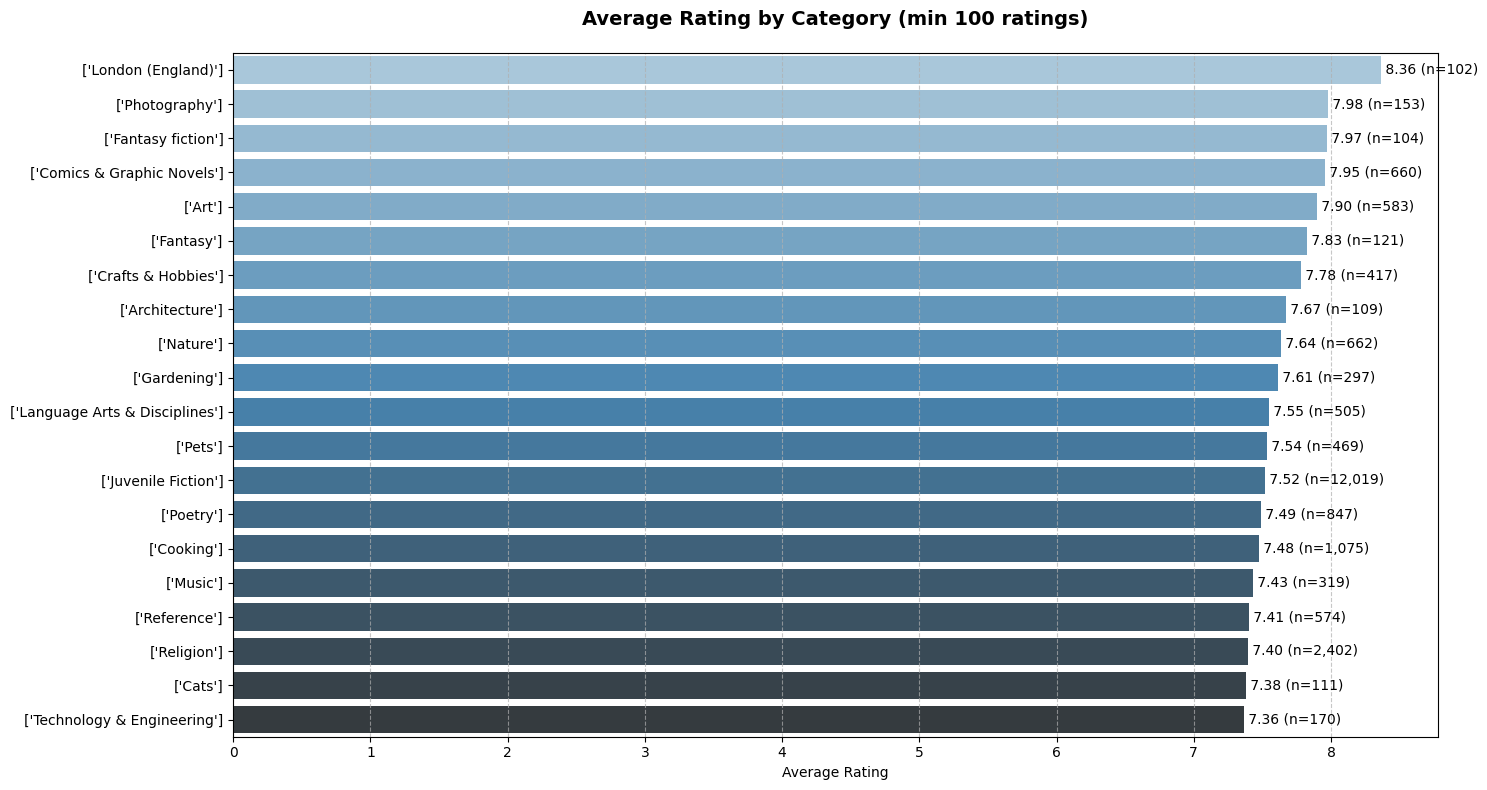


Category Rating Statistics:
Number of categories with >= 100 ratings: 69

Top 5 highest rated categories:
['London (England)']: 8.36 (n=102)
['Photography']: 7.98 (n=153)
['Fantasy fiction']: 7.97 (n=104)
['Comics & Graphic Novels']: 7.95 (n=660)
['Art']: 7.90 (n=583)


In [72]:
# 카테고리별 평균 평점 분석
def extract_categories(category_str):
   if pd.isna(category_str):
       return []
   try:
       return ast.literal_eval(category_str)
   except:
       return [category_str]

# 평점 데이터와 책 데이터 병합
merged_df = pd.merge(books_df, train_ratings_df, on='isbn')

# 카테고리별 평점 집계를 위한 데이터 준비
category_ratings = []
for idx, row in merged_df.iterrows():
   categories = extract_categories(row['category'])
   for cat in categories:
       category_ratings.append({'category': cat, 'rating': row['rating']})

# 데이터프레임으로 변환
category_ratings_df = pd.DataFrame(category_ratings)

# 카테고리별 평균 평점 및 평점 수 계산
category_stats = category_ratings_df.groupby('category').agg({
   'rating': ['count', 'mean', 'std']
}).reset_index()
category_stats.columns = ['category', 'rating_count', 'rating_mean', 'rating_std']

# 일정 수 이상의 평점이 있는 카테고리만 선택 (예: 100개 이상)
category_stats = category_stats[category_stats['rating_count'] >= 100]

# 평균 평점으로 정렬
top_categories = category_stats.nlargest(20, 'rating_mean')

# 시각화
plt.figure(figsize=(15, 8))
ax = sns.barplot(data=top_categories, 
               x='rating_mean', 
               y='category',
               palette='Blues_d')

# 바 끝에 평점 수와 평균 평점 표시
for i, row in enumerate(top_categories.itertuples()):
   ax.text(row.rating_mean, i, 
           f' {row.rating_mean:.2f} (n={row.rating_count:,})', 
           va='center')

plt.title('Average Rating by Category (min 100 ratings)', pad=20, size=14, fontweight='bold')
plt.xlabel('Average Rating')
plt.ylabel('')

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 통계 출력
print("\nCategory Rating Statistics:")
print(f"Number of categories with >= 100 ratings: {len(category_stats)}")
print("\nTop 5 highest rated categories:")
for idx, row in top_categories.head().iterrows():
   print(f"{row['category']}: {row['rating_mean']:.2f} (n={row['rating_count']:,})")

Photography, Fantasy fiction, Comics & Graphic Novels 등 시각적/창작 카테고리가 상위권

대부분의 카테고리가 7.3~8.0 사이에 분포

London (England)은 뭐지?

비슷한 카테고리 정규화/그룹화해서 사용가능할듯

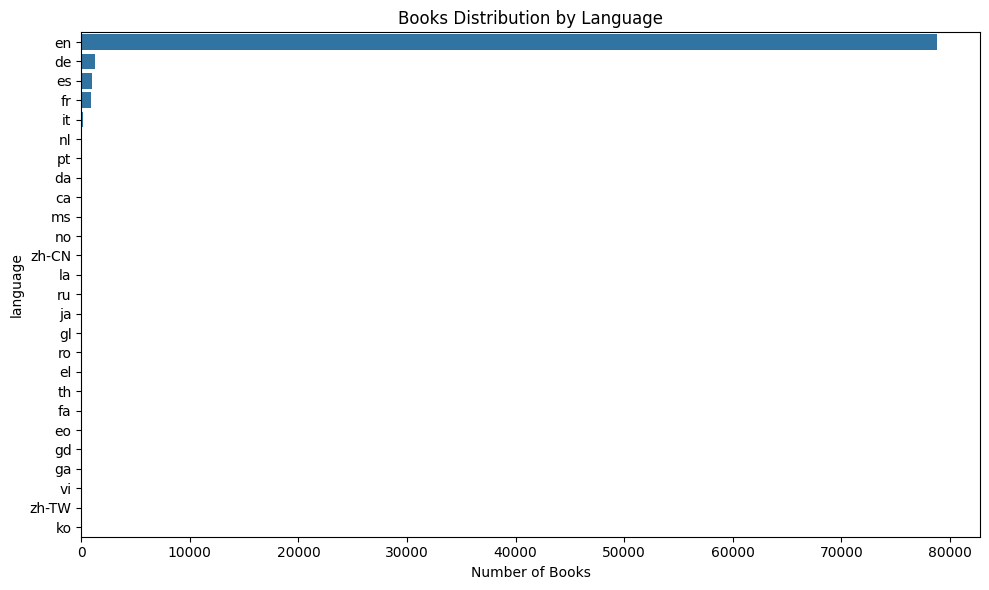

In [27]:
# 5. 언어별 분포
plt.figure(figsize=(10, 6))
language_dist = books_df['language'].value_counts()
sns.barplot(x=language_dist.values, y=language_dist.index)
plt.title('Books Distribution by Language')
plt.xlabel('Number of Books')
plt.tight_layout()
plt.show()

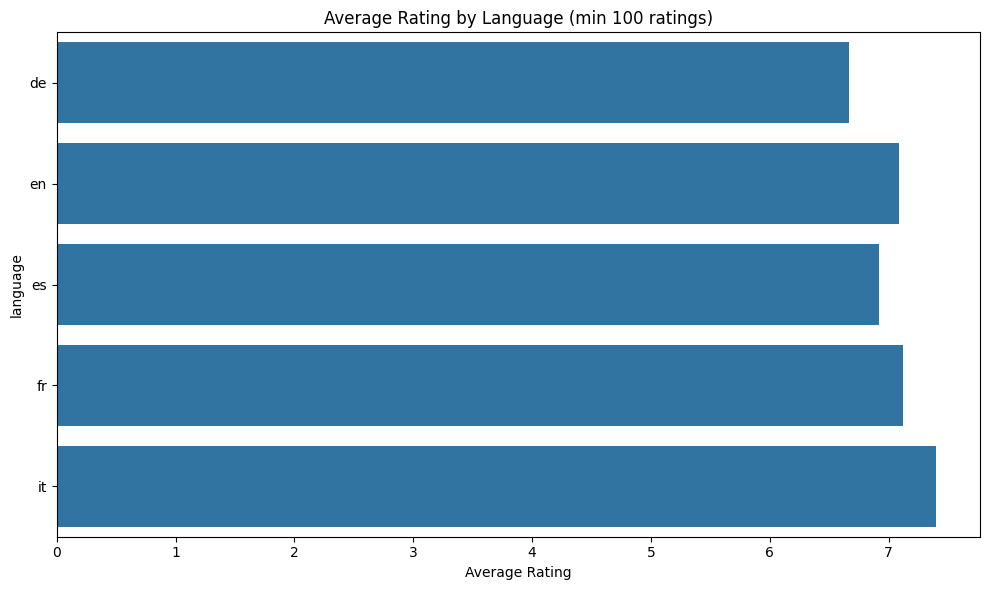

In [28]:
# 언어별 평균 평점
language_ratings = pd.merge(books_df, train_ratings_df, on='isbn')
language_avg = language_ratings.groupby('language').agg({
    'rating': ['count', 'mean']
}).reset_index()
language_avg.columns = ['language', 'rating_count', 'rating_mean']
language_avg = language_avg[language_avg['rating_count'] > 100]

plt.figure(figsize=(10, 6))
sns.barplot(data=language_avg, x='rating_mean', y='language')
plt.title('Average Rating by Language (min 100 ratings)')
plt.xlabel('Average Rating')
plt.tight_layout()
plt.show()

영어 데이터가 너무 많고 평점도 비슷하여 언어도 활용하기 어려울 듯

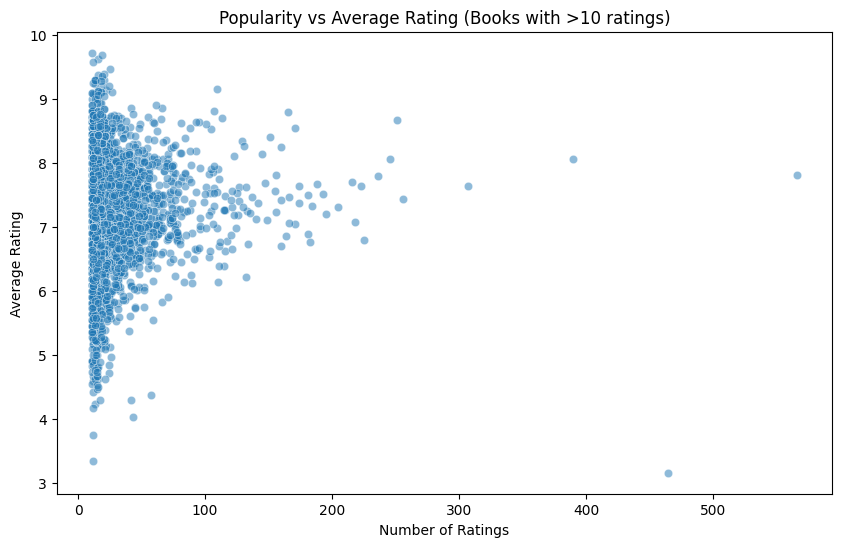

In [ ]:
# 인기도와 평점의 관계
book_stats = train_ratings_df.groupby('isbn').agg({
    'rating': ['count', 'mean', 'std']
}).reset_index()
book_stats.columns = ['isbn', 'rating_count', 'rating_mean', 'rating_std']

plt.figure(figsize=(10, 6))
sns.scatterplot(data=book_stats[book_stats['rating_count'] > 10], 
                x='rating_count', y='rating_mean', alpha=0.5)
plt.title('Popularity vs Average Rating (Books with >10 ratings)')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.show()

평점 수가 적을 때 (0-50개):

평균 평점이 3점부터 10점까지 매우 넓게 분포
극단적인 평가(매우 높거나 낮은)가 많음
평가의 신뢰성이 낮을 수 있음


평점 수가 많아질수록 (100개 이상):

평균 평점이 6-8점 사이로 수렴하는 경향
극단적인 평가가 줄어듦
더 신뢰할 수 있는 평가로 볼 수 있음